In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/usr0/home/naveenr/projects/spurious_concepts/ConceptBottleneck/')
sys.path.append('/usr0/home/naveenr/projects/spurious_concepts')

In [3]:
import torch
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
import torch.nn as nn
import torch.optim as optim
import pickle
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap
import cv2
from copy import copy 
import itertools
import json
import matplotlib.image as mpimg
from collections import Counter
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from itertools import chain


In [4]:
from src.images import *
from src.util import *
from src.models import *
from src.plot import *

# Plots for ICML

## Synthetic Dataset

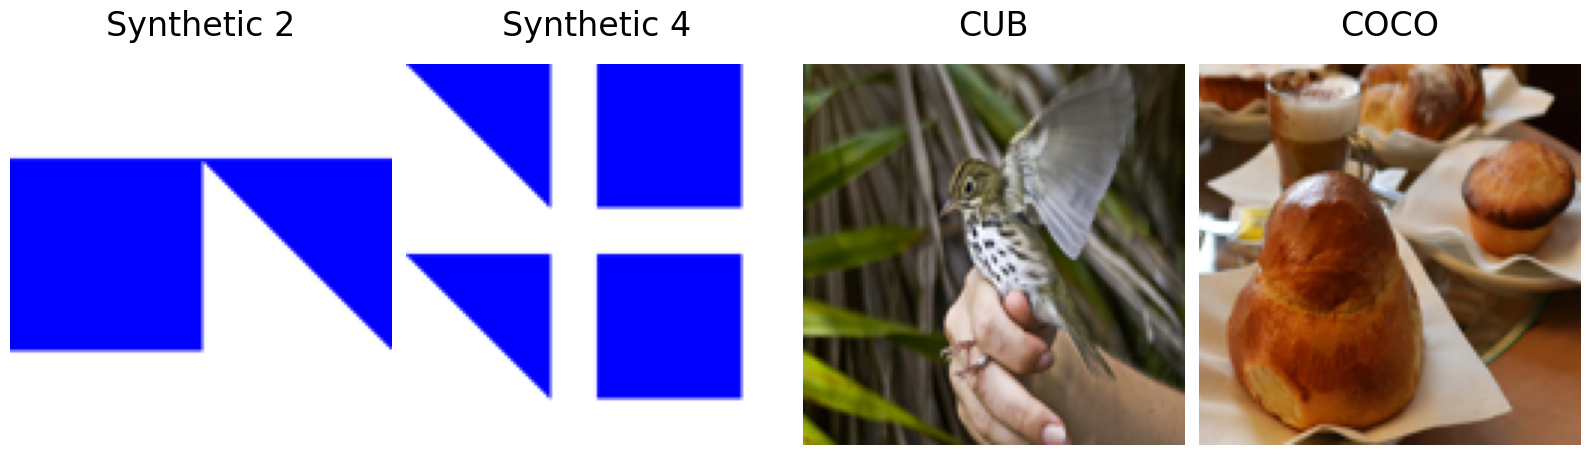

In [5]:
num_objects_list = [2,4]

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(1, 4,figsize=(16, 5))

# Loop through the images and display them in the subplots
for i, num_objects in enumerate(num_objects_list):
    img_num = i+1 

    file_loc = "../../results/synthetic/objects={}_noisy=False_wd=0.0004_model=small3_optimizer=sgd_seed=42/{}.png".format(num_objects,img_num)
    img = Image.open(file_loc)
    
    # Determine the subplot position
    col = i
    img = img.resize((128,128))

    # Display the image in the appropriate subplot
    axs[col].imshow(img)
    axs[col].set_title('Synthetic {}'.format(num_objects),fontsize=24,pad=20)
    axs[col].axis('off')

file_locs = ["../../../../datasets/CUB/images/099.Ovenbird/Ovenbird_0137_92639.jpg","../../../../datasets/coco/images/train/COCO_train2014_000000124835.jpg"]
names = ["CUB","COCO"]
for i in range(len(file_locs)):
    col = i+2
    img = Image.open(file_locs[i])
    img = img.resize((128,128))
    # Display the image in the appropriate subplot
    axs[col].imshow(img)
    axs[col].set_title(names[i],fontsize=24,pad=20)
    axs[col].axis('off')

# Adjust layout
plt.tight_layout()

plt.savefig("../../results/figures/example_dataset.pdf",dpi=300, bbox_inches='tight')

# Show the grid of images
plt.show()

3262e667
2a46b8cc
8ae81be3


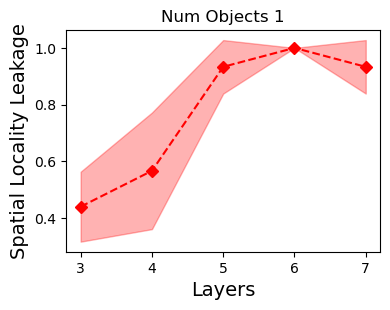

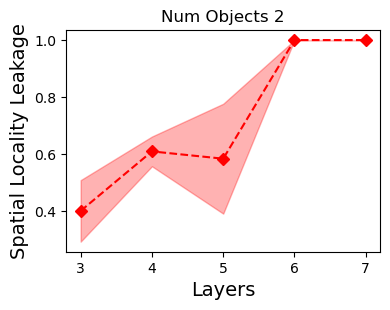

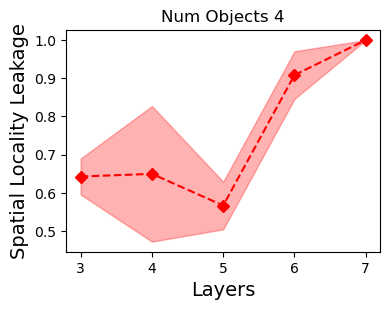

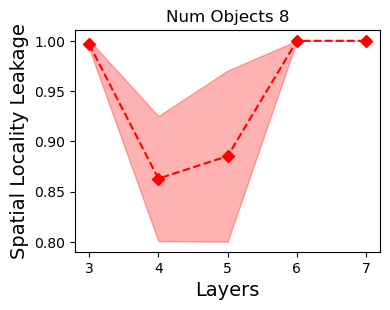

In [6]:

for num_objects in [1,2,4,8]:
    activations_by_size = [] 
    for num_layers in range(3,8):
        activations_by_size.append([])
        for seed in [42,43,44]:
            result_name = get_name_matching_parameters({'dataset': 'synthetic_object/synthetic_{}'.format(num_objects),'num_attributes': 2*num_objects,'seed': seed, 'encoder_model': 'small{}'.format(num_layers), 'epochs': 50, 'debugging': False})
            result_name = result_name[0]

            if num_layers == 3 and num_objects == 1:
                print(result_name)

            results_loc = '../../results/synthetic/{}/results.json'.format(result_name,seed)
            results = json.load(open(results_loc,"r"))
            activations_by_size[-1].append(np.mean(results['adversarial_activations']))

    activations_by_size = np.array(activations_by_size)
    mean_vals = np.mean(activations_by_size,axis=1)
    std_vals = np.std(activations_by_size,axis=1)

    x_vals = list(range(3,8))

    plt.figure(figsize=(4,3))

    plt.fill_between(x_vals, mean_vals - std_vals, mean_vals + std_vals, alpha=0.3,  color='red')
    plt.plot(x_vals, mean_vals, 'rD--')


    # Add labels, legend, and title
    plt.xlabel('Layers',fontsize=14)
    plt.ylabel('Spatial Locality Leakage',fontsize=14)

    plt.tight_layout()

    plt.title("Num Objects {}".format(num_objects))
    plt.savefig("../../results/figures/cnn_activation_{}.pdf".format(num_objects),dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()

In [7]:
result_name = get_name_matching_parameters({'dataset': 'synthetic_object/synthetic_{}'.format(2),'num_attributes': 2*2,'seed': seed, 'encoder_model': 'small{}'.format(7), 'epochs': 50, 'debugging': False})
results = [json.load(open('../../results/synthetic/{}/results.json'.format(r),"r")) for r in result_name]

In [17]:
results[3]

{'train_accuracy': 0.77734375,
 'val_accuracy': 0.7734375,
 'test_accuracy': 0.7734375,
 'adversarial_activations': [0.49398277997970585,
  0.5163145899772644,
  0.5000816345214845,
  0.5014997124671936],
 'parameters': {'seed': 44,
  'encoder_model': 'small7',
  'epochs': 50,
  'num_attributes': 4,
  'expand_dim_encoder': 0,
  'num_middle_encoder': 0,
  'debugging': False,
  'dataset': 'synthetic_object/synthetic_2',
  'weight_decay': 0.04,
  'model_type': 'joint'},
 'run_name': 'd1fa2421'}

['b91127f2', '00d4730c', '4bbc596f', '9e7161df']
['da40bd31', '49b1dbfa', 'e2a1c4b5', 'c5cab327']
['b3f98706', 'da8ce019', 'c90f9fe5', 'd1fa2421']


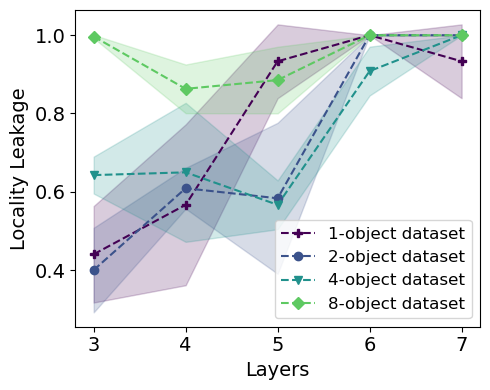

In [9]:
plt.figure(figsize=(5,4))
color_palette = plt.cm.viridis(np.linspace(0, 1, 5))
shapes = ['P','o','v','D','s']
for i,num_objects in enumerate([1,2,4,8]):
    activations_by_size = [] 
    for num_layers in range(3,8):
        activations_by_size.append([])
        for seed in [42,43,44]:
            result_name = get_name_matching_parameters({'dataset': 'synthetic_object/synthetic_{}'.format(num_objects),'num_attributes': 2*num_objects,'seed': seed, 'encoder_model': 'small{}'.format(num_layers), 'epochs': 50, 'debugging': False})
            
            result_name = result_name[0]
            results_loc = '../../results/synthetic/{}/results.json'.format(result_name,seed)
            results = json.load(open(results_loc,"r"))
            activations_by_size[-1].append(np.mean(results['adversarial_activations']))

    activations_by_size = np.array(activations_by_size)
    mean_vals = np.mean(activations_by_size,axis=1)
    std_vals = np.std(activations_by_size,axis=1)

    x_vals = list(range(3,8))

    plt.fill_between(x_vals, mean_vals - std_vals, mean_vals + std_vals, alpha=0.2,  color=color_palette[i])
    plt.plot(x_vals, mean_vals, '{}--'.format(shapes[i]),color=color_palette[i],label=str(num_objects)+"-object dataset")


    # Add labels, legend, and title
plt.xlabel('Layers',fontsize=14)
plt.ylabel('Locality Leakage',fontsize=14)
plt.yticks([0.4,0.6,0.8,1.0],fontsize=14)
plt.legend(fontsize=12)
plt.xticks([3,4,5,6,7],fontsize=14)

plt.tight_layout()

plt.savefig("../../results/figures/cnn_activation_all_objects.pdf",dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

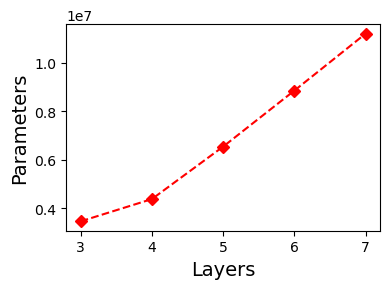

In [17]:
parameters_by_size = [] 

for num_layers in range(3,8):
    joint_model = get_synthetic_model("synthetic_object/synthetic_1",{'dataset': "synthetic_object/synthetic_1",'encoder_model': "small{}".format(num_layers), 'seed': 42, 'epochs': 50, 'num_attributes': 2})
    parameters_by_size.append(sum(p.numel() for p in joint_model.parameters()))

x_vals = list(range(3,8))

plt.figure(figsize=(4,3))

plt.plot(x_vals, parameters_by_size, 'rD--')


# Add labels, legend, and title
plt.xlabel('Layers',fontsize=14)
plt.ylabel('Parameters',fontsize=14)

plt.tight_layout()

plt.savefig("../../results/figures/cnn_parameters.pdf",dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

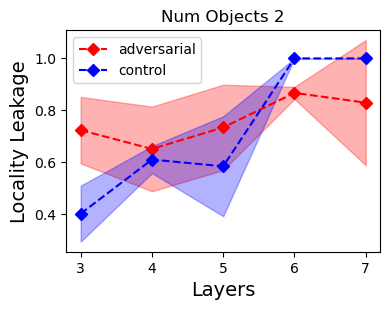

In [10]:
num_objects = 2
activations_by_size = [] 
for num_layers in range(3,8):
    activations_by_size.append([])
    for seed in [42,43,44]:
        result_name = get_name_matching_parameters({'dataset': 'synthetic_object/synthetic_{}'.format(num_objects),'num_attributes': 2*num_objects,'seed': seed, 'encoder_model': 'small{}'.format(num_layers), 'epochs': 50, 'debugging': False, 'train_variation': 'adversarial'})
        result_name = result_name[0]
        results_loc = '../../results/synthetic/{}/results.json'.format(result_name,seed)
        results = json.load(open(results_loc,"r"))
        activations_by_size[-1].append(np.mean(results['adversarial_activations']))

activations_by_size = np.array(activations_by_size)
mean_vals = np.mean(activations_by_size,axis=1)
std_vals = np.std(activations_by_size,axis=1)

x_vals = list(range(3,8))

plt.figure(figsize=(4,3))

plt.fill_between(x_vals, mean_vals - std_vals, mean_vals + std_vals, alpha=0.3,  color='red')
plt.plot(x_vals, mean_vals, 'rD--',label="adversarial")

activations_by_size = [] 
for num_layers in range(3,8):
    activations_by_size.append([])
    for seed in [42,43,44]:
        result_name = get_name_matching_parameters({'dataset': 'synthetic_object/synthetic_{}'.format(num_objects),'num_attributes': 2*num_objects,'seed': seed, 'encoder_model': 'small{}'.format(num_layers), 'epochs': 50, 'debugging': False})
        result_name = result_name[0]
        results_loc = '../../results/synthetic/{}/results.json'.format(result_name,seed)
        results = json.load(open(results_loc,"r"))
        activations_by_size[-1].append(np.mean(results['adversarial_activations']))

activations_by_size = np.array(activations_by_size)
mean_vals = np.mean(activations_by_size,axis=1)
std_vals = np.std(activations_by_size,axis=1)

x_vals = list(range(3,8))

plt.fill_between(x_vals, mean_vals - std_vals, mean_vals + std_vals, alpha=0.3,  color='blue')
plt.plot(x_vals, mean_vals, 'bD--',label="control")



# Add labels, legend, and title
plt.xlabel('Layers',fontsize=14)
plt.ylabel('Locality Leakage',fontsize=14)
plt.legend()

plt.tight_layout()

plt.title("Num Objects {}".format(num_objects))

plt.savefig("../../results/figures/adversarial_training.pdf",dpi=300, bbox_inches='tight')


IndexError: list index out of range

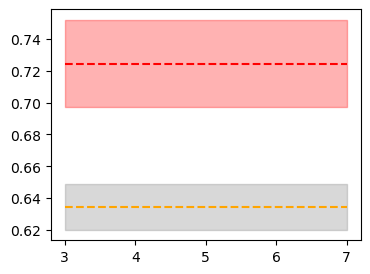

In [52]:
num_objects = 2
activations_by_size = [] 
cem_load = [json.load(open("../../results/cem_results/cem_{}.json".format(seed))) for seed in [42,43,44]]
activations_by_size = [[np.mean(j['adversarial_activations']) for j in cem_load] for i in range(3,8)]

activations_by_size = np.array(activations_by_size)
mean_vals = np.mean(activations_by_size,axis=1)
std_vals = np.std(activations_by_size,axis=1)

x_vals = list(range(3,8))

plt.figure(figsize=(4,3))

plt.fill_between(x_vals, mean_vals - std_vals, mean_vals + std_vals, alpha=0.3,  color='red')
plt.plot(x_vals, mean_vals, 'r--',label="CEM")

probcbm_load = [json.load(open("../../results/probcbm_results/probcbm_{}.json".format(seed))) for seed in [1,2,3]]
activations_by_size = [[np.mean(j['adversarial_activations']) for j in probcbm_load] for i in range(3,8)]

activations_by_size = np.array(activations_by_size)
mean_vals = np.mean(activations_by_size,axis=1)
std_vals = np.std(activations_by_size,axis=1)

x_vals = list(range(3,8))

plt.fill_between(x_vals, mean_vals - std_vals, mean_vals + std_vals, alpha=0.3,  color='grey')
plt.plot(x_vals, mean_vals, '--',label="ProbCBM",color='orange')


activations_by_size = [] 
for num_layers in [7]:
    activations_by_size.append([])
    for seed in [42,43,44]:
        result_name = get_name_matching_parameters({'dataset': 'synthetic_object/synthetic_{}'.format(num_objects),'num_attributes': 2*num_objects,'seed': seed, 'encoder_model': 'small{}'.format(num_layers), 'epochs': 50, 'debugging': False})
        result_name = result_name[0]
        results_loc = '../../results/synthetic/{}/results.json'.format(result_name,seed)
        results = json.load(open(results_loc,"r"))
        activations_by_size[-1].append(np.mean(results['adversarial_activations']))

activations_by_size = np.array(activations_by_size)
mean_vals = np.mean(activations_by_size,axis=1)
std_vals = np.std(activations_by_size,axis=1)

x_vals = list(range(3,8))

plt.fill_between(x_vals, mean_vals - std_vals, mean_vals + std_vals, alpha=0.3,  color='blue')
plt.plot(x_vals, mean_vals, 'bD--',label="control")



# Add labels, legend, and title
plt.xlabel('Layers',fontsize=14)
plt.ylabel('Locality Leakage',fontsize=14)
plt.legend()

plt.tight_layout()

plt.title("Num Objects {}".format(num_objects))

plt.savefig("../../results/figures/cem_model.pdf",dpi=300, bbox_inches='tight')


In [79]:
get_name_matching_parameters({'dataset': 'synthetic_object/synthetic_{}'.format(4),'num_concept_combinations': 2})

[]

In [9]:
num_objects = 2
activations_by_size = [] 
cem_load = [json.load(open("../../results/cem_results/cem_{}.json".format(seed))) for seed in [42,43,44]]
activations_by_size = [[np.mean(j['adversarial_activations']) for j in cem_load] for i in range(3,8)]

activations_by_size = np.array(activations_by_size)
cem_mean_vals = np.mean(activations_by_size,axis=1)
cem_std_vals = np.std(activations_by_size,axis=1)

probcbm_load = [json.load(open("../../results/probcbm_results/probcbm_{}.json".format(seed))) for seed in [1,2,3]]
activations_by_size = [[np.mean(j['adversarial_activations']) for j in probcbm_load] for i in range(3,8)]


activations_by_size = np.array(activations_by_size)
probcbm_mean_vals = np.mean(activations_by_size,axis=1)
probcbm_std_vals = np.std(activations_by_size,axis=1)


activations_by_size = [] 
for num_layers in [7]:
    activations_by_size.append([])
    for seed in [42,43,44]:
        result_name = get_name_matching_parameters({'dataset': 'synthetic_object/synthetic_{}'.format(num_objects),'num_attributes': 2*num_objects,'seed': seed, 'encoder_model': 'small{}'.format(num_layers), 'epochs': 50, 'debugging': False})
        result_name = result_name[0]
        results_loc = '../../results/synthetic/{}/results.json'.format(result_name,seed)
        results = json.load(open(results_loc,"r"))
        activations_by_size[-1].append((np.mean(results['adversarial_activations'])))

activations_by_size = np.array(activations_by_size)
mean_vals = np.mean(activations_by_size,axis=1)
std_vals = np.std(activations_by_size,axis=1)

latex_table = """Baseline (7 Layer) & Synthetic &                              100.0\\% $\\pm$ 0.0\%     &      {} $\\pm$ {}       & -         & -                           \\\\
CEM                & Synthetic &                           100.0\\% $\\pm$ 0.0\%          &     {} $\\pm$ {}       & -                    & -                \\\\
ProbCBM            & Synthetic &                           100.0\\% $\\pm$ 0.0\%      &         {} $\\pm$ {}        & -      & -                              \\\\
"""
print(latex_table.format("{:.3f}".format(mean_vals[0]),"{:.3f}".format(std_vals[0]),"{:.3f}".format(cem_mean_vals[0]),"{:.3f}".format(cem_std_vals[0]),"{:.3f}".format(probcbm_mean_vals[0]),"{:.3f}".format(probcbm_std_vals[0])))

Baseline (7 Layer) & Synthetic &                              100.0\% $\pm$ 0.0\%     &      1.000 $\pm$ 0.000       & -         & -                           \\
CEM                & Synthetic &                           100.0\% $\pm$ 0.0\%          &     0.724 $\pm$ 0.028       & -                    & -                \\
ProbCBM            & Synthetic &                           100.0\% $\pm$ 0.0\%      &         0.635 $\pm$ 0.014        & -      & -                              \\



In [68]:
mean_vals

array([1.])

1 42
1 43
1 44
2 42
2 43
2 44
4 42
4 43
4 44
8 42
8 43
8 44


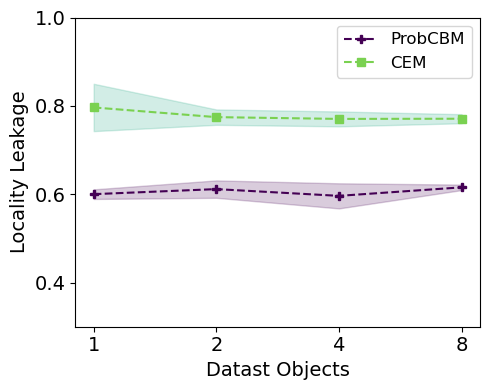

In [8]:
plt.figure(figsize=(5,4))
color_palette = plt.cm.viridis(np.linspace(0, 1, 6))
shapes = ['P','o','v','D','s']

activations_by_size = []
for num_objects in [1,2,4,8]:
    activations_by_size.append([])
    for seed in [42,43,44]:
        result_name = get_name_matching_parameters({'dataset': 'synthetic_{}'.format(num_objects),'seed': seed,'model_type': 'probcbm', })
        result_name = result_name[0]
        results_loc = '../../results/synthetic/{}/results.json'.format(result_name,seed)
        results = json.load(open(results_loc,"r"))
        activations_by_size[-1].append(np.mean(results['adversarial_activations']))

activations_by_size = np.array(activations_by_size)
mean_vals = np.mean(activations_by_size,axis=1)
std_vals = np.std(activations_by_size,axis=1)

x_vals = list(range(0,4))

plt.fill_between(x_vals, mean_vals - std_vals, mean_vals + std_vals, alpha=0.2,  color=color_palette[0])
plt.plot(x_vals, mean_vals, shapes[0]+'--',color=color_palette[0],label='ProbCBM')

activations_by_size = []
for num_objects in [1,2,4,8]:
    activations_by_size.append([])
    for seed in [42,43,44]:
        print(num_objects,seed)
        result_name = get_name_matching_parameters({'dataset': 'synthetic_{}'.format(num_objects),'seed': seed,'model_type': 'cem'})
        result_name = result_name[0]
        results_loc = '../../results/synthetic/{}/results.json'.format(result_name,seed)
        results = json.load(open(results_loc,"r"))
        activations_by_size[-1].append(np.mean(results['adversarial_activations']))

activations_by_size = np.array(activations_by_size)
mean_vals = np.mean(activations_by_size,axis=1)
std_vals = np.std(activations_by_size,axis=1)

x_vals = list(range(0,4))

plt.fill_between(x_vals, mean_vals - std_vals, mean_vals + std_vals, alpha=0.2,  color=color_palette[3])
plt.plot(x_vals, mean_vals, shapes[4]+'--',color=color_palette[4],label='CEM')


    # Add labels, legend, and title
plt.xlabel('Datast Objects',fontsize=14)
plt.ylabel('Locality Leakage',fontsize=14)
plt.yticks([0.4,0.6,0.8,1.0],fontsize=14)
plt.ylim([0.3,1.0])
plt.legend(fontsize=12)
plt.xticks(x_vals,[1,2,4,8],fontsize=14)

plt.tight_layout()

plt.savefig("../../results/figures/cem_probcbm.pdf",dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

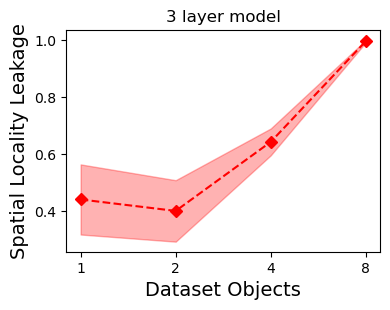

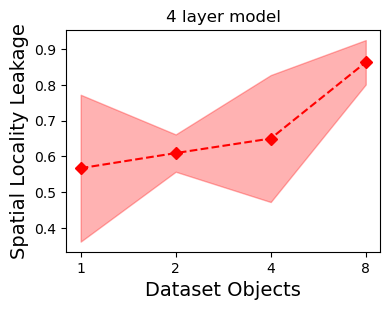

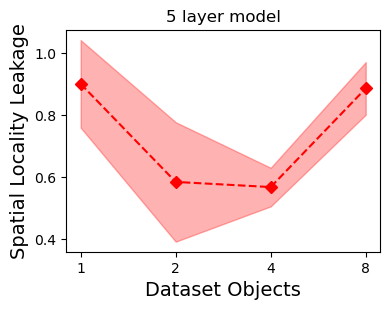

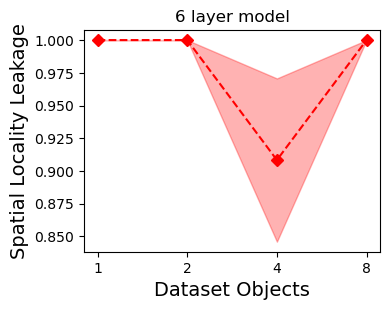

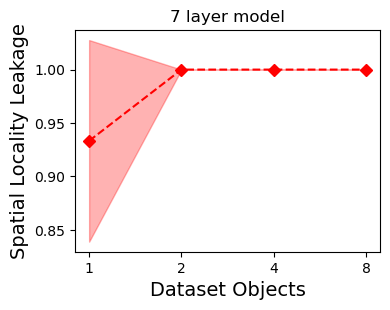

In [18]:
for num_layers in range(3,8):

    activations_by_size = [] 
    for num_objects in [1,2,4,8]:
        activations_by_size.append([])
        for seed in [42,43,44]:
            result_name = get_name_matching_parameters({'dataset': 'synthetic_object/synthetic_{}'.format(num_objects),'num_attributes': 2*num_objects,'seed': seed, 'encoder_model': 'small{}'.format(num_layers), 'epochs': 50, 'debugging': False})
            result_name = result_name[0]
            results_loc = '../../results/synthetic/{}/results.json'.format(result_name,seed)
            results = json.load(open(results_loc,"r"))
            activations_by_size[-1].append(np.mean(results['adversarial_activations']))

    activations_by_size = np.array(activations_by_size)
    mean_vals = np.mean(activations_by_size,axis=1)
    std_vals = np.std(activations_by_size,axis=1)

    x_vals = list(range(0,4))

    plt.figure(figsize=(4,3))

    plt.fill_between(x_vals, mean_vals - std_vals, mean_vals + std_vals, alpha=0.3,  color='red')
    plt.plot(x_vals, mean_vals, 'rD--')


    # Add labels, legend, and title
    plt.xlabel('Dataset Objects',fontsize=14)
    plt.ylabel('Spatial Locality Leakage',fontsize=14)
    plt.xticks(x_vals,[1,2,4,8])

    plt.tight_layout()

    plt.title("{} layer model".format(num_layers))
    plt.savefig("../../results/figures/cnn_activation_nobjects_{}.pdf".format(num_layers),dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()

0.8 1 42
0.9999999996545808 1 43
1.0 1 44
0.4 2 42
0.8500000000000039 2 43
0.5 2 44
0.4999994933605194 4 42
0.6500020115558613 4 43
0.55000000894076 4 44
0.8595542154328313 8 42
0.7964809567191571 8 43
1.0 8 44


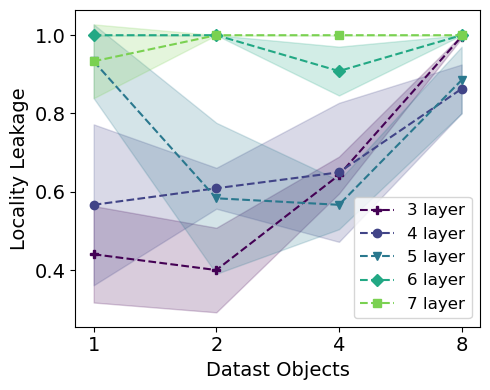

In [16]:
plt.figure(figsize=(5,4))
color_palette = plt.cm.viridis(np.linspace(0, 1, 6))
shapes = ['P','o','v','D','s']

for i,num_layers in enumerate(range(3,8)):

    activations_by_size = [] 
    for num_objects in [1,2,4,8]:
        activations_by_size.append([])
        for seed in [42,43,44]:
            result_name = get_name_matching_parameters({'dataset': 'synthetic_object/synthetic_{}'.format(num_objects),'num_attributes': 2*num_objects,'seed': seed, 'encoder_model': 'small{}'.format(num_layers), 'epochs': 50, 'debugging': False})
            result_name = result_name[0]
            results_loc = '../../results/synthetic/{}/results.json'.format(result_name,seed)
            results = json.load(open(results_loc,"r"))
            if num_layers == 5:
                print(np.mean(results['adversarial_activations']),num_objects,seed)
            activations_by_size[-1].append(np.mean(results['adversarial_activations']))

    activations_by_size = np.array(activations_by_size)
    mean_vals = np.mean(activations_by_size,axis=1)
    std_vals = np.std(activations_by_size,axis=1)

    x_vals = list(range(0,4))

    plt.fill_between(x_vals, mean_vals - std_vals, mean_vals + std_vals, alpha=0.2,  color=color_palette[i])
    plt.plot(x_vals, mean_vals, '{}--'.format(shapes[i]),color=color_palette[i],label=str(num_layers)+" layer")


    # Add labels, legend, and title
plt.xlabel('Datast Objects',fontsize=14)
plt.ylabel('Locality Leakage',fontsize=14)
plt.yticks([0.4,0.6,0.8,1.0],fontsize=14)
plt.legend(fontsize=12)
plt.xticks(x_vals,[1,2,4,8],fontsize=14)

plt.tight_layout()

plt.savefig("../../results/figures/cnn_activation_all_layers.pdf",dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

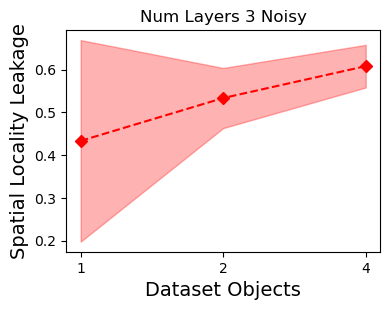

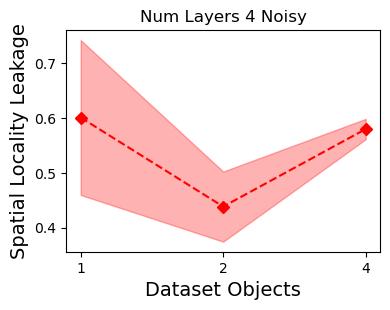

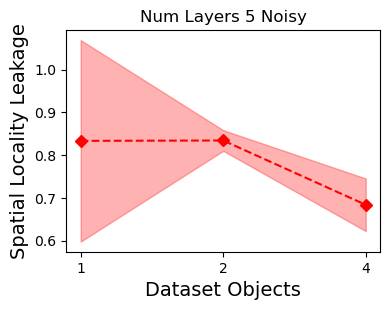

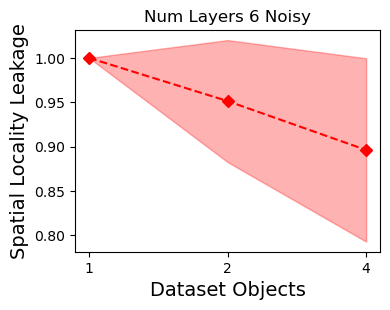

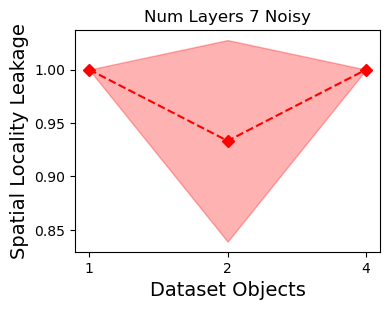

In [5]:
for num_layers in range(3,8):
    activations_by_size = [] 
    for num_objects in [1,2,4]:
        activations_by_size.append([])
        for seed in [42,43,44]:
            result_name = get_name_matching_parameters({'dataset': 'synthetic_object/synthetic_{}_noisy'.format(num_objects),'num_attributes': 2*num_objects,'seed': seed, 'encoder_model': 'small{}'.format(num_layers), 'epochs': 50, 'debugging': False})
            result_name = result_name[0]
            results_loc = '../../results/synthetic/{}/results.json'.format(result_name,seed)
            results = json.load(open(results_loc,"r"))
            activations_by_size[-1].append(np.mean(results['adversarial_activations']))

    activations_by_size = np.array(activations_by_size)
    mean_vals = np.mean(activations_by_size,axis=1)
    std_vals = np.std(activations_by_size,axis=1)

    x_vals = list(range(0,3))

    plt.figure(figsize=(4,3))

    plt.fill_between(x_vals, mean_vals - std_vals, mean_vals + std_vals, alpha=0.3,  color='red')
    plt.plot(x_vals, mean_vals, 'rD--')


    # Add labels, legend, and title
    plt.xlabel('Dataset Objects',fontsize=14)
    plt.ylabel('Spatial Locality Leakage',fontsize=14)
    plt.xticks(x_vals,[1,2,4])

    plt.tight_layout()

    plt.title("Num Layers {} Noisy".format(num_layers))
    plt.savefig("../../results/figures/cnn_activation_nobjects_{}.pdf".format(num_layers),dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()

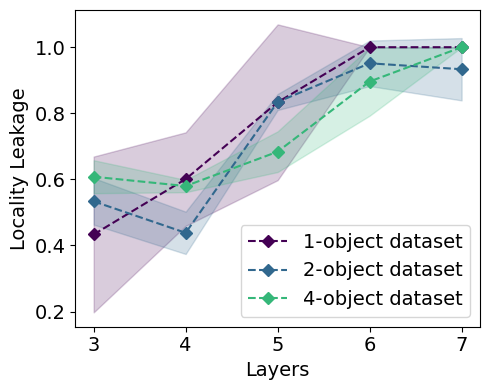

In [19]:
plt.figure(figsize=(5,4))
color_palette = plt.cm.viridis(np.linspace(0, 1, 4))
for i,num_objects in enumerate([1,2,4]):
    activations_by_size = [] 
    for num_layers in range(3,8):
        activations_by_size.append([])
        for seed in [42,43,44]:
            result_name = get_name_matching_parameters({'dataset': 'synthetic_object/synthetic_{}_noisy'.format(num_objects),'num_attributes': 2*num_objects,'seed': seed, 'encoder_model': 'small{}'.format(num_layers), 'epochs': 50, 'debugging': False})
            result_name = result_name[0]
            results_loc = '../../results/synthetic/{}/results.json'.format(result_name,seed)
            results = json.load(open(results_loc,"r"))
            activations_by_size[-1].append(np.mean(results['adversarial_activations']))

    activations_by_size = np.array(activations_by_size)
    mean_vals = np.mean(activations_by_size,axis=1)
    std_vals = np.std(activations_by_size,axis=1)

    x_vals = list(range(3,8))

    plt.fill_between(x_vals, mean_vals - std_vals, mean_vals + std_vals, alpha=0.2,  color=color_palette[i])
    plt.plot(x_vals, mean_vals, 'D--',color=color_palette[i],label=str(num_objects)+"-object dataset")


    # Add labels, legend, and title
plt.xlabel('Layers',fontsize=14)
plt.ylabel('Locality Leakage',fontsize=14)
plt.yticks([0.2,0.4,0.6,0.8,1.0],fontsize=14)
plt.legend(fontsize=14)
plt.xticks([3,4,5,6,7],fontsize=14)

plt.tight_layout()

plt.savefig("../../results/figures/cnn_activation_all_objects_noisy.pdf",dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

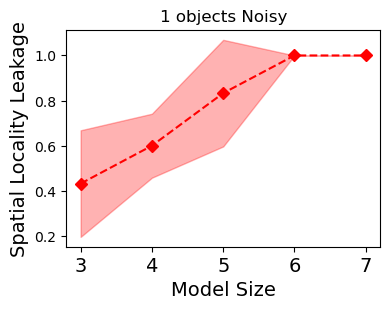

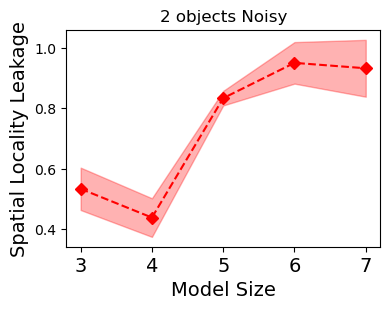

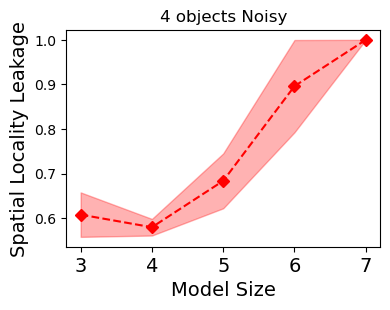

In [17]:
for num_objects in [1,2,4]:
    activations_by_size = [] 
    for num_layers in range(3,8):
        activations_by_size.append([])
        for seed in [42,43,44]:
            result_name = get_name_matching_parameters({'dataset': 'synthetic_object/synthetic_{}_noisy'.format(num_objects),'num_attributes': 2*num_objects,'seed': seed, 'encoder_model': 'small{}'.format(num_layers), 'epochs': 50, 'debugging': False})
            result_name = result_name[0]
            results_loc = '../../results/synthetic/{}/results.json'.format(result_name,seed)
            results = json.load(open(results_loc,"r"))
            activations_by_size[-1].append(np.mean(results['adversarial_activations']))

    activations_by_size = np.array(activations_by_size)
    mean_vals = np.mean(activations_by_size,axis=1)
    std_vals = np.std(activations_by_size,axis=1)

    x_vals = list(range(3,8))

    plt.figure(figsize=(4,3))

    plt.fill_between(x_vals, mean_vals - std_vals, mean_vals + std_vals, alpha=0.3,  color='red')
    plt.plot(x_vals, mean_vals, 'rD--')


    # Add labels, legend, and title
    plt.xlabel('Model Size',fontsize=14)
    plt.ylabel('Spatial Locality Leakage',fontsize=14)
    plt.xticks(x_vals,fontsize=14)

    plt.tight_layout()

    plt.title("{} objects Noisy".format(num_objects))
    plt.savefig("../../results/figures/cnn_activation_nobjects_noisy_{}.pdf".format(num_objects),dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()

### Impact of Regularization

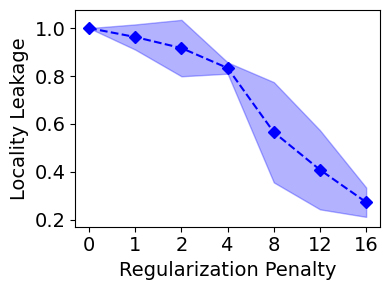

In [11]:
all_json = [json.load(open("../../results/synthetic/l2_norm/results_{}.json".format(seed))) for seed in [42,43,44]]
all_activation = [i['activation_values'] for i in all_json]
lamb_vals = all_json[0]['lambda']
all_activation = np.array(all_activation)
all_activation_mean = np.mean(all_activation,axis=0)
all_activation_std = np.std(all_activation,axis=0)

x_vals = list(range(len(lamb_vals)))

plt.figure(figsize=(4,3))

plt.fill_between(x_vals, all_activation_mean - all_activation_std, all_activation_mean + all_activation_std, alpha=0.3,  color='blue')
plt.plot(x_vals, all_activation_mean, 'bD--')


# Add labels, legend, and title
plt.xlabel('Regularization Penalty',fontsize=14)
plt.ylabel('Locality Leakage',fontsize=14)
plt.xticks(x_vals,lamb_vals,fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()

plt.savefig("../../results/figures/regularization_sll.pdf",dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

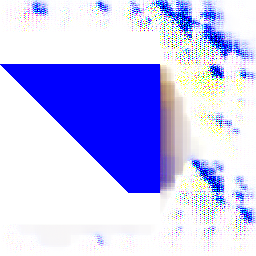

In [33]:
file_loc = "../../results/synthetic/l2_norm/example_4_42.png"
img = Image.open(file_loc)
img

array([1.        , 0.96275762, 0.9166751 , 0.83333339, 0.56513517,
       0.40842333, 0.27316601])

### Impact of Training Epochs

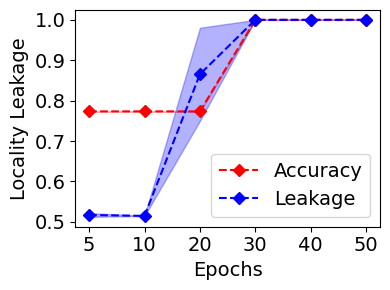

In [19]:
activations_by_size = [] 
accuracy_by_size = []
for epochs in [5,10,20,30,40,50]:
    activations_by_size.append([])
    accuracy_by_size.append([])
    for seed in [42,43,44]:
        result_name = get_name_matching_parameters({'dataset': 'synthetic_object/synthetic_2','num_attributes': 4,'seed': seed, 'encoder_model': 'small7', 'epochs': epochs, 'debugging': False})
        result_name = result_name[0]
        results_loc = '../../results/synthetic/{}/results.json'.format(result_name,seed)
        results = json.load(open(results_loc,"r"))
        activations_by_size[-1].append(np.mean(results['adversarial_activations']))
        accuracy_by_size[-1].append(results['test_accuracy'])

activations_by_size = np.array(activations_by_size)
mean_vals = np.mean(activations_by_size,axis=1)
std_vals = np.std(activations_by_size,axis=1)

accuracy_by_size = np.array(accuracy_by_size)
mean_accuracy = np.mean(accuracy_by_size,axis=1)
std_accuracy = np.std(accuracy_by_size,axis=1)


x_vals = list(range(0,6))

plt.figure(figsize=(4,3))

plt.fill_between(x_vals, mean_accuracy - std_accuracy, mean_accuracy + std_accuracy, alpha=0.3,  color='red')
plt.plot(x_vals, mean_accuracy, 'rD--',label='Accuracy')


plt.fill_between(x_vals, mean_vals - std_vals, mean_vals + std_vals, alpha=0.3,  color='blue')
plt.plot(x_vals, mean_vals, 'bD--',label='Leakage')



# Add labels, legend, and title
plt.xlabel('Epochs',fontsize=14)
plt.ylabel('Locality Leakage',fontsize=14)
plt.xticks(x_vals,[5,10,20,30,40,50],fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=14,loc='lower right')

plt.tight_layout()

plt.savefig("../../results/figures/cnn_activation_epochs.pdf",dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

### Impact of Model Size

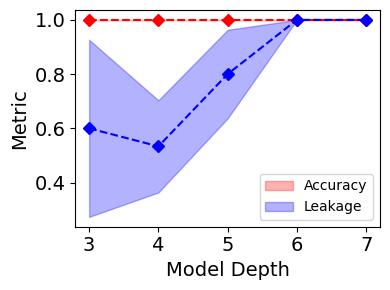

In [26]:
seeds = [42,43,44]
num_layers = 1
accuracy_values = []
leakage_values = []
for depth in [3,4,5,6,7]:
    accuracy_values.append([])
    leakage_values.append([])

    for seed in seeds:
        d = {'dataset': 'synthetic_object/synthetic_{}'.format(1),'num_attributes': 2,'seed': seed, 'encoder_model': 'equal_parameter{}'.format(depth) }
        if depth == 7:
            d['lr'] = 0.1
        result_name = get_name_matching_parameters(d)
        result_name = result_name[0]
        results_loc = '../../results/synthetic/{}/results.json'.format(result_name,seed)
        results = json.load(open(results_loc,"r"))

        accuracy_values[-1].append(results['test_accuracy'])
        leakage_values[-1].append(np.mean(results['adversarial_activations']))

accuracy_values = np.array(accuracy_values).T
leakage_values = np.array(leakage_values).T

mean_accuracy = np.mean(accuracy_values,axis=0)
std_accuracy = np.std(accuracy_values,axis=0)

mean_leakage = np.mean(leakage_values,axis=0)
std_leakage = np.std(leakage_values,axis=0)

x_vals = [3,4,5,6,7]

plt.figure(figsize=(4,3))

plt.fill_between(x_vals, mean_accuracy - std_accuracy, mean_accuracy + std_accuracy, alpha=0.3, label="Accuracy", color='red')
plt.plot(x_vals, mean_accuracy, 'rD--')

plt.fill_between(x_vals, mean_leakage - std_leakage, mean_leakage + std_leakage, alpha=0.3, label="Leakage", color='blue')
plt.plot(x_vals, mean_leakage, 'bD--')

# Add labels, legend, and title
plt.xlabel('Model Depth',fontsize=14)
plt.ylabel('Metric',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right') 
plt.tight_layout()

plt.savefig("../../results/figures/cnn_parameters_fixed.pdf",dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

#### Receptive Field Analysis

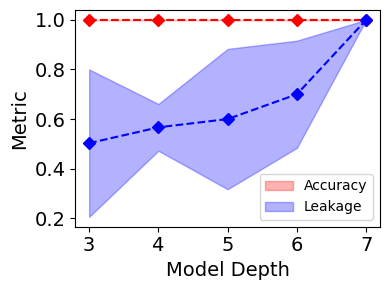

In [11]:
seeds = [42,43,44]
num_layers = 1
accuracy_values = []
leakage_values = []
for depth in [3,4,5,6,7]:
    accuracy_values.append([])
    leakage_values.append([])

    for seed in seeds:
        d = {'dataset': 'synthetic_object/synthetic_{}'.format(1),'num_attributes': 2,'seed': seed, 'encoder_model': 'receptive_field{}'.format(depth) }
        if depth == 7:
            d['lr'] = 0.1
        result_name = get_name_matching_parameters(d)
        result_name = result_name[0]
        results_loc = '../../results/synthetic/{}/results.json'.format(result_name,seed)
        results = json.load(open(results_loc,"r"))

        accuracy_values[-1].append(results['test_accuracy'])
        leakage_values[-1].append(np.mean(results['adversarial_activations']))

accuracy_values = np.array(accuracy_values).T
leakage_values = np.array(leakage_values).T

mean_accuracy = np.mean(accuracy_values,axis=0)
std_accuracy = np.std(accuracy_values,axis=0)

mean_leakage = np.mean(leakage_values,axis=0)
std_leakage = np.std(leakage_values,axis=0)

x_vals = [3,4,5,6,7]

plt.figure(figsize=(4,3))

plt.fill_between(x_vals, mean_accuracy - std_accuracy, mean_accuracy + std_accuracy, alpha=0.3, label="Accuracy", color='red')
plt.plot(x_vals, mean_accuracy, 'rD--')

plt.fill_between(x_vals, mean_leakage - std_leakage, mean_leakage + std_leakage, alpha=0.3, label="Leakage", color='blue')
plt.plot(x_vals, mean_leakage, 'bD--')

# Add labels, legend, and title
plt.xlabel('Model Depth',fontsize=14)
plt.ylabel('Metric',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right') 
plt.tight_layout()

plt.savefig("../../results/figures/receptive_field.pdf",dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

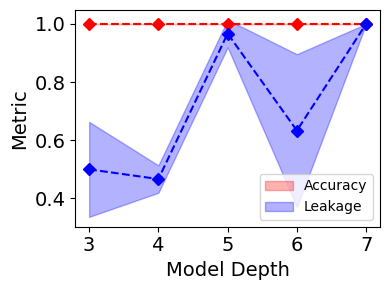

In [9]:
seeds = [42,43,44]
num_layers = 1
accuracy_values = []
leakage_values = []
for depth in [3,4,5,6,7]:
    accuracy_values.append([])
    leakage_values.append([])

    for seed in seeds:
        d = {'dataset': 'synthetic_object/synthetic_{}'.format(1),'num_attributes': 2,'seed': seed, 'encoder_model': 'small{}'.format(depth), 'use_residual': True }
        result_name = get_name_matching_parameters(d)
        result_name = result_name[0]
        results_loc = '../../results/synthetic/{}/results.json'.format(result_name,seed)
        results = json.load(open(results_loc,"r"))
        accuracy_values[-1].append(results['test_accuracy'])
        leakage_values[-1].append(np.mean(results['adversarial_activations']))

accuracy_values = np.array(accuracy_values).T
leakage_values = np.array(leakage_values).T

mean_accuracy = np.mean(accuracy_values,axis=0)
std_accuracy = np.std(accuracy_values,axis=0)

mean_leakage = np.mean(leakage_values,axis=0)
std_leakage = np.std(leakage_values,axis=0)

x_vals = [3,4,5,6,7]

plt.figure(figsize=(4,3))

plt.fill_between(x_vals, mean_accuracy - std_accuracy, mean_accuracy + std_accuracy, alpha=0.3, label="Accuracy", color='red')
plt.plot(x_vals, mean_accuracy, 'rD--')

plt.fill_between(x_vals, mean_leakage - std_leakage, mean_leakage + std_leakage, alpha=0.3, label="Leakage", color='blue')
plt.plot(x_vals, mean_leakage, 'bD--')

# Add labels, legend, and title
plt.xlabel('Model Depth',fontsize=14)
plt.ylabel('Metric',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right') 
plt.tight_layout()

plt.savefig("../../results/figures/residual.pdf",dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

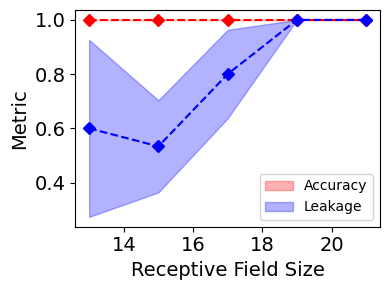

In [11]:
seeds = [42,43,44]
num_layers = 1
accuracy_values = []
leakage_values = []
for depth in [3,4,5,6,7]:
    accuracy_values.append([])
    leakage_values.append([])

    for seed in seeds:
        d = {'dataset': 'synthetic_object/synthetic_{}'.format(1),'num_attributes': 2,'seed': seed, 'encoder_model': 'equal_parameter{}'.format(depth) }
        if depth == 7:
            d['lr'] = 0.1
        result_name = get_name_matching_parameters(d)
        result_name = result_name[0]
        results_loc = '../../results/synthetic/{}/results.json'.format(result_name,seed)
        results = json.load(open(results_loc,"r"))

        accuracy_values[-1].append(results['test_accuracy'])
        leakage_values[-1].append(np.mean(results['adversarial_activations']))

accuracy_values = np.array(accuracy_values).T
leakage_values = np.array(leakage_values).T

mean_accuracy = np.mean(accuracy_values,axis=0)
std_accuracy = np.std(accuracy_values,axis=0)

mean_leakage = np.mean(leakage_values,axis=0)
std_leakage = np.std(leakage_values,axis=0)

receptive_fields = [13,15,17,19,21]
x_vals = receptive_fields 

plt.figure(figsize=(4,3))

plt.fill_between(x_vals, mean_accuracy - std_accuracy, mean_accuracy + std_accuracy, alpha=0.3, label="Accuracy", color='red')
plt.plot(x_vals, mean_accuracy, 'rD--')

plt.fill_between(x_vals, mean_leakage - std_leakage, mean_leakage + std_leakage, alpha=0.3, label="Leakage", color='blue')
plt.plot(x_vals, mean_leakage, 'bD--')

# Add labels, legend, and title
plt.xlabel('Receptive Field Size',fontsize=14)
plt.ylabel('Metric',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right') 
plt.tight_layout()

plt.savefig("../../results/figures/cnn_parameters_receptive.pdf",dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

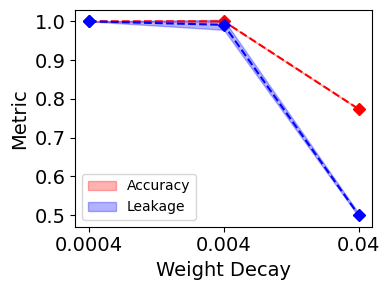

In [23]:
seeds = [42,43,44]
num_layers = 1
accuracy_values = []
leakage_values = []
for weight_decay in [0.04,0.004,0.0004][::-1]:
    accuracy_values.append([])
    leakage_values.append([])

    for seed in seeds:
        result_name = get_name_matching_parameters({'dataset': 'synthetic_object/synthetic_{}'.format(2),'num_attributes': 4,'seed': seed, 'encoder_model': 'small7','weight_decay': weight_decay })
        result_name = result_name[0]
        results_loc = '../../results/synthetic/{}/results.json'.format(result_name,seed)
        results = json.load(open(results_loc,"r"))

        accuracy_values[-1].append(results['test_accuracy'])
        leakage_values[-1].append(np.mean(results['adversarial_activations']))

accuracy_values = np.array(accuracy_values).T
leakage_values = np.array(leakage_values).T

mean_accuracy = np.mean(accuracy_values,axis=0)
std_accuracy = np.std(accuracy_values,axis=0)

mean_leakage = np.mean(leakage_values,axis=0)
std_leakage = np.std(leakage_values,axis=0)

x_vals = [1,2,3]

plt.figure(figsize=(4,3))

plt.fill_between(x_vals, mean_accuracy - std_accuracy, mean_accuracy + std_accuracy, alpha=0.3, label="Accuracy", color='red')
plt.plot(x_vals, mean_accuracy, 'rD--')

plt.fill_between(x_vals, mean_leakage - std_leakage, mean_leakage + std_leakage, alpha=0.3, label="Leakage", color='blue')
plt.plot(x_vals, mean_leakage, 'bD--')

plt.xticks(x_vals,[0.04,0.004,0.0004][::-1],fontsize=14)
plt.yticks(fontsize=14)

# Add labels, legend, and title
plt.xlabel('Weight Decay',fontsize=14)
plt.ylabel('Metric',fontsize=14)
plt.legend() 
plt.tight_layout()

plt.savefig("../../results/figures/cnn_weight_decay.pdf",dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

### Impact of Pruning

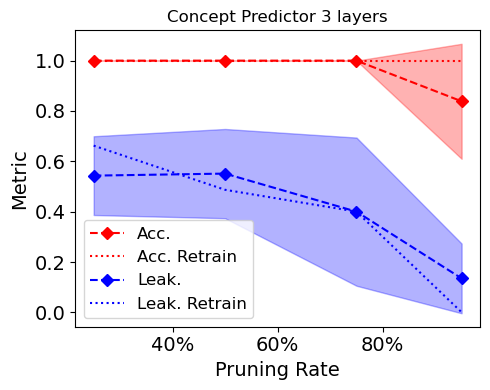

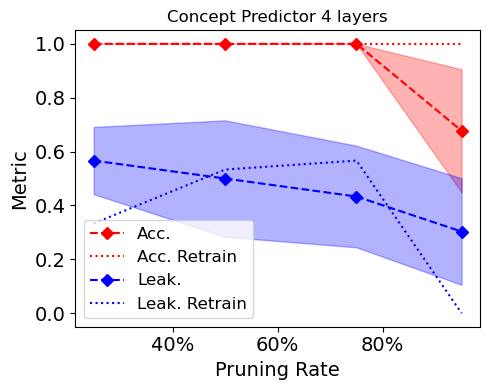

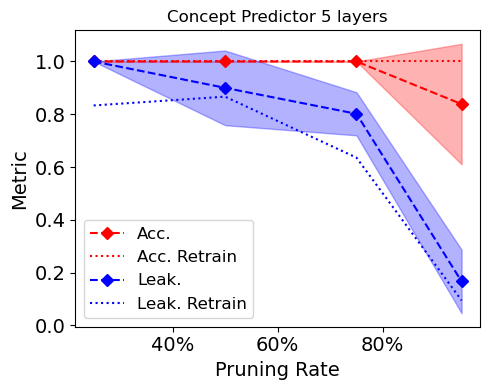

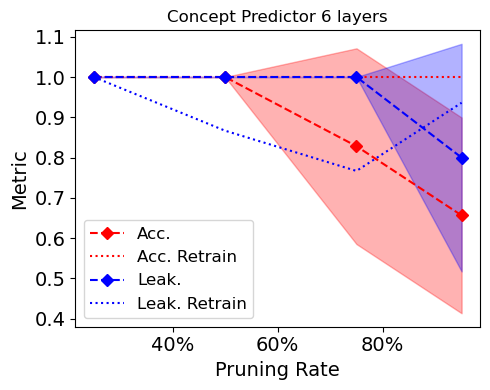

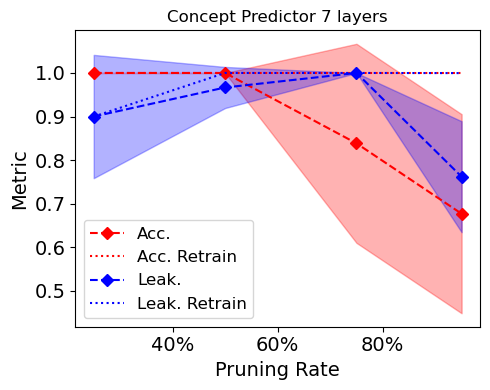

In [25]:
seeds = [42,43,44]
num_layers = 1

for encoder_model in ['small3','small4','small5','small6','small7']:
    accuracy_values = []
    leakage_values = []

    accuracy_values_retrain = []
    leakage_values_retrain = []


    for pruning_rate in [0.25,0.5,0.75,0.95]:
        accuracy_values.append([])
        leakage_values.append([])

        accuracy_values_retrain.append([])
        leakage_values_retrain.append([])

        for seed in seeds:
            for retrain_epochs in [0,5]:
                # TODO: Fix this, double parameters
                result_name = get_name_matching_parameters({'dataset_name': 'synthetic_object/synthetic_1', 'encoder_model': encoder_model,'seed': seed, 'prune_rate': pruning_rate, 'retrain_epochs': retrain_epochs},folder_name="results/pruning")
                result_name = result_name[0]
                results_loc = '../../results/pruning/{}.json'.format(result_name,seed)
                results = json.load(open(results_loc,"r"))

                if retrain_epochs == 0:
                    accuracy_values[-1].append(results['test_accuracy'])
                    leakage_values[-1].append(np.mean(results['adversarial_activations']))
                else:
                    accuracy_values_retrain[-1].append(results['test_accuracy'])
                    leakage_values_retrain[-1].append(np.mean(results['adversarial_activations']))


    accuracy_values = np.array(accuracy_values).T
    leakage_values = np.array(leakage_values).T
    accuracy_values_retrain = np.array(accuracy_values_retrain).T
    leakage_values_retrain = np.array(leakage_values_retrain).T

    mean_accuracy = np.mean(accuracy_values,axis=0)
    std_accuracy = np.std(accuracy_values,axis=0)
    mean_accuracy_retrain = np.mean(accuracy_values_retrain,axis=0)
    std_accuracy_retrain = np.std(accuracy_values_retrain,axis=0)

    mean_leakage = np.mean(leakage_values,axis=0)
    std_leakage = np.std(leakage_values,axis=0)
    mean_leakage_retrain = np.mean(leakage_values_retrain,axis=0)
    std_leakage_retrain = np.std(leakage_values_retrain,axis=0)

    x_vals = [0.25,0.5,0.75,0.95]

    plt.figure(figsize=(5,4))

    plt.fill_between(x_vals, mean_accuracy - std_accuracy, mean_accuracy + std_accuracy, alpha=0.3, color='red')
    plt.plot(x_vals, mean_accuracy, 'rD--', label="Acc.")
    plt.plot(x_vals, mean_accuracy_retrain, 'r:', label="Acc. Retrain")

    plt.fill_between(x_vals, mean_leakage - std_leakage, mean_leakage + std_leakage, alpha=0.3, color='blue')
    plt.plot(x_vals, mean_leakage, 'bD--', label="Leak.")
    plt.plot(x_vals, mean_leakage_retrain, 'b:', label="Leak. Retrain")

    plt.title("Concept Predictor {} layers".format(encoder_model.replace("small","")))
    # Add labels, legend, and title
    plt.xlabel('Pruning Rate',fontsize=14)
    plt.xticks([0.4,0.6,0.8],["40%","60%","80%"],fontsize=14)
    plt.ylabel('Metric',fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=12,loc='lower left') 
    plt.tight_layout()
    
    plt.savefig("../../results/figures/small_{}_pruning.pdf".format(encoder_model.replace("small","")),dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()

In [ ]:
seeds = [42,43,44]
num_layers = 1

for encoder_model in ['small3','small4','small5','small6','small7']:
    accuracy_values = []
    leakage_values = []

    accuracy_values_retrain = []
    leakage_values_retrain = []


    for pruning_rate in [0.25,0.5,0.75,0.95]:
        accuracy_values.append([])
        leakage_values.append([])

        accuracy_values_retrain.append([])
        leakage_values_retrain.append([])

        for seed in seeds:
            for retrain_epochs in [0,5]:
                result_name = get_name_matching_parameters({'dataset_name': 'synthetic_object/synthetic_2', 'encoder_model': encoder_model,'seed': seed, 'prune_rate': pruning_rate, 'retrain_epochs': retrain_epochs},folder_name="results/pruning")
                result_name = result_name[0]
                results_loc = '../../results/pruning/{}.json'.format(result_name,seed)
                results = json.load(open(results_loc,"r"))

                if retrain_epochs == 0:
                    accuracy_values[-1].append(results['test_accuracy'])
                    leakage_values[-1].append(np.mean(results['adversarial_activations']))
                else:
                    accuracy_values_retrain[-1].append(results['test_accuracy'])
                    leakage_values_retrain[-1].append(np.mean(results['adversarial_activations']))


    accuracy_values = np.array(accuracy_values).T
    leakage_values = np.array(leakage_values).T
    accuracy_values_retrain = np.array(accuracy_values_retrain).T
    leakage_values_retrain = np.array(leakage_values_retrain).T

    mean_accuracy = np.mean(accuracy_values,axis=0)
    std_accuracy = np.std(accuracy_values,axis=0)
    mean_accuracy_retrain = np.mean(accuracy_values_retrain,axis=0)
    std_accuracy_retrain = np.std(accuracy_values_retrain,axis=0)

    mean_leakage = np.mean(leakage_values,axis=0)
    std_leakage = np.std(leakage_values,axis=0)
    mean_leakage_retrain = np.mean(leakage_values_retrain,axis=0)
    std_leakage_retrain = np.std(leakage_values_retrain,axis=0)

    x_vals = [0.25,0.5,0.75,0.95]

    plt.figure(figsize=(4,3))

    plt.fill_between(x_vals, mean_accuracy - std_accuracy, mean_accuracy + std_accuracy, alpha=0.3, color='red')
    plt.plot(x_vals, mean_accuracy, 'rD--', label="Accuracy")
    plt.plot(x_vals, mean_accuracy_retrain, 'r:', label="Accuracy Retrain")

    plt.fill_between(x_vals, mean_leakage - std_leakage, mean_leakage + std_leakage, alpha=0.3, color='blue')
    plt.plot(x_vals, mean_leakage, 'bD--', label="Leakage")
    plt.plot(x_vals, mean_leakage_retrain, 'b:', label="Leakage Retrain")

    plt.title("Encoder model {}".format(encoder_model))
    # Add labels, legend, and title
    plt.xlabel('Pruning Rate',fontsize=14)
    plt.ylabel('Accuracy/Leakage',fontsize=14)
    plt.legend() 
    plt.tight_layout()

    # Show the plot
    plt.show()

In [ ]:
seeds = [42,43,44]
num_layers = 1

for encoder_model in ['small3','small4','small5','small6']:
    accuracy_values = []
    leakage_values = []

    accuracy_values_retrain = []
    leakage_values_retrain = []


    for pruning_rate in [0.25,0.5,0.75,0.95]:
        accuracy_values.append([])
        leakage_values.append([])

        accuracy_values_retrain.append([])
        leakage_values_retrain.append([])

        for seed in seeds:
            for retrain_epochs in [0,5]:
                result_name = get_name_matching_parameters({'dataset_name': 'synthetic_object/synthetic_4', 'encoder_model': encoder_model,'seed': seed, 'prune_rate': pruning_rate, 'retrain_epochs': retrain_epochs},folder_name="results/pruning")
                result_name = result_name[0]
                results_loc = '../../results/pruning/{}.json'.format(result_name,seed)
                results = json.load(open(results_loc,"r"))

                if retrain_epochs == 0:
                    accuracy_values[-1].append(results['test_accuracy'])
                    leakage_values[-1].append(np.mean(results['adversarial_activations']))
                else:
                    accuracy_values_retrain[-1].append(results['test_accuracy'])
                    leakage_values_retrain[-1].append(np.mean(results['adversarial_activations']))


    accuracy_values = np.array(accuracy_values).T
    leakage_values = np.array(leakage_values).T
    accuracy_values_retrain = np.array(accuracy_values_retrain).T
    leakage_values_retrain = np.array(leakage_values_retrain).T

    mean_accuracy = np.mean(accuracy_values,axis=0)
    std_accuracy = np.std(accuracy_values,axis=0)
    mean_accuracy_retrain = np.mean(accuracy_values_retrain,axis=0)
    std_accuracy_retrain = np.std(accuracy_values_retrain,axis=0)

    mean_leakage = np.mean(leakage_values,axis=0)
    std_leakage = np.std(leakage_values,axis=0)
    mean_leakage_retrain = np.mean(leakage_values_retrain,axis=0)
    std_leakage_retrain = np.std(leakage_values_retrain,axis=0)

    x_vals = [0.25,0.5,0.75,0.95]

    plt.figure(figsize=(4,3))

    plt.fill_between(x_vals, mean_accuracy - std_accuracy, mean_accuracy + std_accuracy, alpha=0.3, color='red')
    plt.plot(x_vals, mean_accuracy, 'rD--', label="Accuracy")
    plt.plot(x_vals, mean_accuracy_retrain, 'r:', label="Accuracy Retrain")

    plt.fill_between(x_vals, mean_leakage - std_leakage, mean_leakage + std_leakage, alpha=0.3, color='blue')
    plt.plot(x_vals, mean_leakage, 'bD--', label="Leakage")
    plt.plot(x_vals, mean_leakage_retrain, 'b:', label="Leakage Retrain")

    plt.title("Encoder model {}".format(encoder_model))
    # Add labels, legend, and title
    plt.xlabel('Pruning Rate',fontsize=14)
    plt.ylabel('Accuracy/Leakage',fontsize=14)
    plt.legend() 
    plt.tight_layout()

    # Show the plot
    plt.show()

In [ ]:
seeds = [42,43,44]
num_layers = 1

for middle_layers in [5,10,15]:
    accuracy_values = []
    leakage_values = []

    accuracy_values_retrain = []
    leakage_values_retrain = []


    for pruning_rate in [0.25,0.5,0.75,0.95]:
        accuracy_values.append([])
        leakage_values.append([])

        accuracy_values_retrain.append([])
        leakage_values_retrain.append([])

        for seed in seeds:
            for retrain_epochs in [0,5]:
                # TODO: Fix this, double parameters
                result_name = get_name_matching_parameters({'dataset_name': 'synthetic_object/synthetic_1','encoder_model': 'mlp','seed': seed, 'prune_rate': pruning_rate, 'retrain_epochs': retrain_epochs, 'expand_dim_encoder': middle_layers},folder_name="results/pruning")
                result_name = result_name[0]
                results_loc = '../../results/pruning/{}.json'.format(result_name,seed)
                results = json.load(open(results_loc,"r"))

                if retrain_epochs == 0:
                    accuracy_values[-1].append(results['test_accuracy'])
                    leakage_values[-1].append(np.mean(results['adversarial_activations']))
                else:
                    accuracy_values_retrain[-1].append(results['test_accuracy'])
                    leakage_values_retrain[-1].append(np.mean(results['adversarial_activations']))


    accuracy_values = np.array(accuracy_values).T
    leakage_values = np.array(leakage_values).T
    accuracy_values_retrain = np.array(accuracy_values_retrain).T
    leakage_values_retrain = np.array(leakage_values_retrain).T

    mean_accuracy = np.mean(accuracy_values,axis=0)
    std_accuracy = np.std(accuracy_values,axis=0)
    mean_accuracy_retrain = np.mean(accuracy_values_retrain,axis=0)
    std_accuracy_retrain = np.std(accuracy_values_retrain,axis=0)

    mean_leakage = np.mean(leakage_values,axis=0)
    std_leakage = np.std(leakage_values,axis=0)
    mean_leakage_retrain = np.mean(leakage_values_retrain,axis=0)
    std_leakage_retrain = np.std(leakage_values_retrain,axis=0)

    x_vals = [0.25,0.5,0.75,0.95]

    plt.figure(figsize=(4,3))

    plt.fill_between(x_vals, mean_accuracy - std_accuracy, mean_accuracy + std_accuracy, alpha=0.3, color='red')
    plt.plot(x_vals, mean_accuracy, 'rD--', label="Accuracy")
    plt.plot(x_vals, mean_accuracy_retrain, 'r:', label="Accuracy Retrain")

    plt.fill_between(x_vals, mean_leakage - std_leakage, mean_leakage + std_leakage, alpha=0.3, color='blue')
    plt.plot(x_vals, mean_leakage, 'bD--', label="Leakage")
    plt.plot(x_vals, mean_leakage_retrain, 'b:', label="Leakage Retrain")

    plt.title("MLP with {} width".format(middle_layers))
    # Add labels, legend, and title
    plt.xlabel('Pruning Rate',fontsize=14)
    plt.ylabel('Accuracy/Leakage',fontsize=14)
    plt.legend() 
    plt.tight_layout()

    # Show the plot
    plt.show()

### MLP Results

In [ ]:
results_matrix = [[["" for k in range(2)] for i in range(3)] for j in range(3)]

for i,num_layers in enumerate([1,2,3]):
    for j,model_size in enumerate([5,10,15]):
        activation_list = []

        for seed in [42,43,44]:
            result_name = get_name_matching_parameters({'num_attributes': 2,'seed': seed, 'encoder_model': 'mlp', 'num_middle_encoder': num_layers, 'expand_dim_encoder': model_size })
            result_name = result_name[0]
            results_loc = '../../results/synthetic/{}/results.json'.format(result_name,seed)
            results = json.load(open(results_loc,"r"))
            activation_list.append(min(results['adversarial_activations']))

        results_matrix[i][j][0] = str("{:.2f}".format(np.mean(activation_list)))
        results_matrix[i][j][1] = str("{:.2f}".format(np.std(activation_list)))

latex_table = """\\begin{{table}}[]
\\begin{{tabular}}{{@{{}}lll@{{}}}}
\centering 
\\toprule
Depth & Width & Activation \\\\ \\midrule
1     & 5     & {} $\\pm$ {}       \\\\
      & 10    & {} $\\pm$ {}        \\\\
      & 15    & {} $\\pm$ {}        \\\\ 
2     & 5     & {} $\\pm$ {}        \\\\
      & 10    & {} $\\pm$ {}        \\\\
      & 15    & {} $\\pm$ {}        \\\\
3     & 5     & {} $\\pm$ {}        \\\\
      & 10    & {} $\\pm$ {}        \\\\
      & 15    & {} $\\pm$ {}        \\\\ \\bottomrule 
\\end{{tabular}}
\\caption{{Activation results by MLP model Depth and Width. We see that, with increasing width, MLP models have increasingly large activations. However, contrary to intuitions, increasing width has no clear pattern.}}
\\end{{table}}""".format(*chain.from_iterable(list(chain.from_iterable(results_matrix))))

print(latex_table)

In [ ]:
seeds = [42,43,44]
num_layers = 1
accuracy_values = []
leakage_values = []
for model_size in [1,2,3,4,5]:
    accuracy_values.append([])
    leakage_values.append([])

    for seed in seeds:
        result_name = get_name_matching_parameters({'num_attributes': 2,'seed': seed, 'encoder_model': 'mlp', 'num_middle_encoder': num_layers, 'expand_dim_encoder': model_size })
        result_name = result_name[0]
        results_loc = '../../results/synthetic/{}/results.json'.format(result_name,seed)
        results = json.load(open(results_loc,"r"))

        accuracy_values[-1].append(results['test_accuracy'])
        leakage_values[-1].append(np.mean(results['adversarial_activations']))

accuracy_values = np.array(accuracy_values).T
leakage_values = np.array(leakage_values).T

mean_accuracy = np.mean(accuracy_values,axis=0)
std_accuracy = np.std(accuracy_values,axis=0)

mean_leakage = np.mean(leakage_values,axis=0)
std_leakage = np.std(leakage_values,axis=0)

x_vals = [1,2,3,4,5]

plt.figure(figsize=(4,3))

plt.fill_between(x_vals, mean_accuracy - std_accuracy, mean_accuracy + std_accuracy, alpha=0.3, label="Accuracy", color='red')
plt.plot(x_vals, mean_accuracy, 'rD--')

plt.fill_between(x_vals, mean_leakage - std_leakage, mean_leakage + std_leakage, alpha=0.3, label="Leakage", color='blue')
plt.plot(x_vals, mean_leakage, 'bD--')

# Add labels, legend, and title
plt.xlabel('Filters',fontsize=14)
plt.ylabel('Accuracy/Leakage',fontsize=14)
plt.legend() 
plt.tight_layout()

plt.savefig("../../results/figures/mlp_filters.pdf",dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
seeds = [42,43,44]
file_names = ["../../results/synthetic/mlp_analysis/results_{}.json".format(seed) for seed in seeds]
data = [json.load(open(i)) for i in file_names]

accuracy_values = np.array([i['accuracy'] for i in data])
leakage_values = np.array([i['spatial_locality_leakage'] for i in data])

mean_accuracy = np.mean(accuracy_values,axis=0)
std_accuracy = np.std(accuracy_values,axis=0)

mean_leakage = np.mean(leakage_values,axis=0)
std_leakage = np.std(leakage_values,axis=0)

x_vals = [1,2,3,4,5]

plt.figure(figsize=(4,3))

plt.fill_between(x_vals, mean_accuracy - std_accuracy, mean_accuracy + std_accuracy, alpha=0.3,  color='red')
plt.plot(x_vals, mean_accuracy, 'rD--')

plt.fill_between(x_vals, mean_leakage - std_leakage, mean_leakage + std_leakage, alpha=0.3,  color='blue')
plt.plot(x_vals, mean_leakage, 'bD--')

# Add labels, legend, and title
plt.xlabel('Filters',fontsize=14)
plt.ylabel('Accuracy/Leakage',fontsize=14)
plt.legend() 
plt.tight_layout()

plt.savefig("../../results/figures/mlp_filters_trained.pdf",dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(1, 2)

# Loop through the images and display them in the subplots
for i in range(2):
    file_loc = "../../results/synthetic/mlp_filter_{}.png".format(i)
    img = Image.open(file_loc)
    
    # Determine the subplot position
    col = i
    
    # Display the image in the appropriate subplot
    axs[col].imshow(img)
    axs[col].axis('off')

# Adjust layout
plt.tight_layout()

plt.savefig("../../results/figures/mlp_filters.pdf",dpi=300, bbox_inches='tight')

# Show the grid of images
plt.show()

### Training Additions

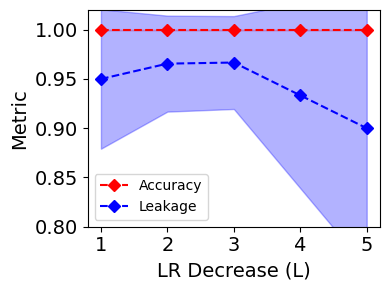

In [24]:
seeds = [42,43,44]

accuracy_values = []
leakage_values = []

for scale_lr in [1,2,3,4,5]:
    accuracy_values.append([])
    leakage_values.append([])
    for seed in seeds:
        result_name = get_name_matching_parameters({'train_variation': 'half', 'scale_lr': scale_lr, 'seed': seed,'debugging': False})
        result_name = result_name[0]
        results_loc = '../../results/synthetic/{}/results.json'.format(result_name,seed)
        results = json.load(open(results_loc,"r"))
        
        leakage_values[-1].append(np.mean(results['adversarial_activations']))
        accuracy_values[-1].append(results['test_accuracy'])

accuracy_values = np.array(accuracy_values).T
leakage_values = np.array(leakage_values).T

mean_accuracy = np.mean(accuracy_values,axis=0)
std_accuracy = np.std(accuracy_values,axis=0)

mean_leakage = np.mean(leakage_values,axis=0)
std_leakage = np.std(leakage_values,axis=0)

x_vals = [1,2,3,4,5]

plt.figure(figsize=(4,3))

plt.fill_between(x_vals, mean_accuracy - std_accuracy, mean_accuracy + std_accuracy, alpha=0.3,  color='red')
plt.plot(x_vals, mean_accuracy, 'rD--',label='Accuracy')

plt.fill_between(x_vals, mean_leakage - std_leakage, mean_leakage + std_leakage, alpha=0.3,  color='blue')
plt.plot(x_vals, mean_leakage, 'bD--',label='Leakage')

# Add labels, legend, and title
plt.xlabel('LR Decrease (L)',fontsize=14)
plt.ylabel('Metric',fontsize=14)
plt.ylim([0.8,1.02])
plt.legend() 
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.tight_layout()

plt.savefig("../../results/figures/half_loss.pdf",dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

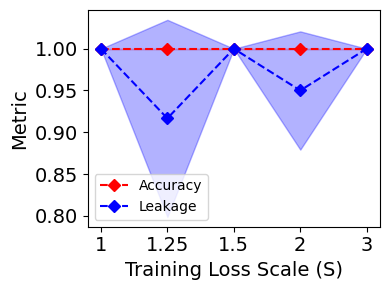

In [27]:
seeds = [42,43,44]

accuracy_values = []
leakage_values = []

for scale_factor in [1,1.25,1.5,2,3]:
    accuracy_values.append([])
    leakage_values.append([])
    for seed in seeds:
        result_name = get_name_matching_parameters({'train_variation': 'loss', 'scale_factor': scale_factor, 'seed': seed,'debugging': False})
        result_name = result_name[0]
        results_loc = '../../results/synthetic/{}/results.json'.format(result_name,seed)
        results = json.load(open(results_loc,"r"))
        
        leakage_values[-1].append(np.mean(results['adversarial_activations']))
        accuracy_values[-1].append(results['test_accuracy'])

accuracy_values = np.array(accuracy_values).T
leakage_values = np.array(leakage_values).T

mean_accuracy = np.mean(accuracy_values,axis=0)
std_accuracy = np.std(accuracy_values,axis=0)

mean_leakage = np.mean(leakage_values,axis=0)
std_leakage = np.std(leakage_values,axis=0)

x_vals =[1,2,3,4,5]

plt.figure(figsize=(4,3))

plt.fill_between(x_vals, mean_accuracy - std_accuracy, mean_accuracy + std_accuracy, alpha=0.3,  color='red')
plt.plot(x_vals, mean_accuracy, 'rD--',label='Accuracy')

plt.fill_between(x_vals, mean_leakage - std_leakage, mean_leakage + std_leakage, alpha=0.3,  color='blue')
plt.plot(x_vals, mean_leakage, 'bD--',label='Leakage')

# Add labels, legend, and title
plt.xlabel('Training Loss Scale (S)',fontsize=14)
plt.ylabel('Metric',fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(x_vals,[1,1.25,1.5,2,3],fontsize=14)

plt.legend() 
plt.tight_layout()

plt.savefig("../../results/figures/train_variation_concept_correlation.pdf",dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

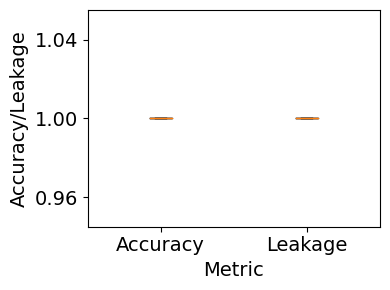

In [40]:
seeds = [42,43,44]

accuracy_values = []
leakage_values = []

for seed in seeds:
    result_name = get_name_matching_parameters({'model_type': 'independent', 'seed': seed,'debugging': False})
    result_name = result_name[0]
    results_loc = '../../results/synthetic/{}/results.json'.format(result_name,seed)
    results = json.load(open(results_loc,"r"))
    
    leakage_values.append(np.mean(results['adversarial_activations']))
    accuracy_values.append(results['test_accuracy'])

plt.figure(figsize=(4,3))
all_data = [accuracy_values,leakage_values]
plt.boxplot(all_data, labels=['Accuracy', 'Leakage'])
plt.xticks(fontsize=14)
plt.yticks([0.96,1.0,1.04],fontsize=14)


plt.xlabel('Metric',fontsize=14)
plt.ylabel('Accuracy/Leakage',fontsize=14)
plt.tight_layout()

plt.savefig("../../results/figures/independent_models.pdf",dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

['00d4730c']
['49b1dbfa']
['da8ce019']


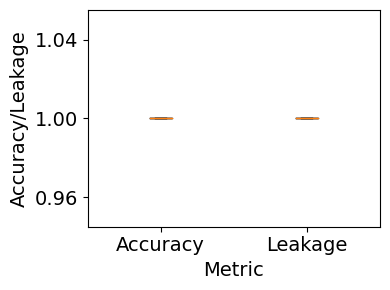

In [52]:
seeds = [42,43,44]

accuracy_values = []
leakage_values = []

for seed in seeds:
    result_name = get_name_matching_parameters({"dataset": "synthetic_object/synthetic_2", "model_type": "independent", "num_attributes": 4, "num_classes": 2, "seed": seed, "epochs": 50,  "encoder_model": "small7", "weight_decay": 0.0004, "attr_loss_weight": 1.0, "optimizer": "sgd", "expand_dim_encoder": 0, "num_middle_encoder": 0, "load_model": "none", "train_variation": "none", "debugging": False})#, "scale_lr": 5, "scale_factor": 1.5})
    print(result_name)
    result_name = result_name[0]
    results_loc = '../../results/synthetic/{}/results.json'.format(result_name,seed)
    results = json.load(open(results_loc,"r"))
    
    leakage_values.append(np.mean(results['adversarial_activations']))
    accuracy_values.append(results['test_accuracy'])

plt.figure(figsize=(4,3))
all_data = [accuracy_values,leakage_values]
plt.boxplot(all_data, labels=['Accuracy', 'Leakage'])
plt.xticks(fontsize=14)
plt.yticks([0.96,1.0,1.04],fontsize=14)


plt.xlabel('Metric',fontsize=14)
plt.ylabel('Accuracy/Leakage',fontsize=14)
plt.tight_layout()

plt.savefig("../../results/figures/independent_models.pdf",dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

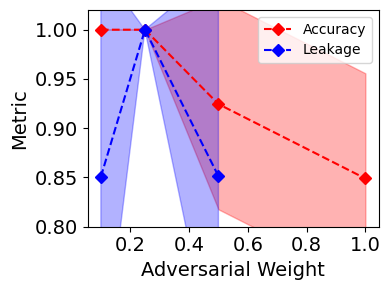

In [16]:
seeds = [42,43,44]

accuracy_values = []
leakage_values = []

for adversarial_weight in [0.1,0.25,0.5,1.0]:
    accuracy_values.append([])
    leakage_values.append([])
    for seed in seeds:
        result_name = get_name_matching_parameters({'train_variation': 'adversarial', 'adversarial_epsilon': 0.01,'adversarial_weight': adversarial_weight, 'seed': seed,'debugging': False})
        result_name = result_name[0]
        results_loc = '../../results/synthetic/{}/results.json'.format(result_name,seed)
        results = json.load(open(results_loc,"r"))
        
        leakage_values[-1].append(np.mean(results['adversarial_activations']))
        accuracy_values[-1].append(results['test_accuracy'])

accuracy_values = np.array(accuracy_values).T
leakage_values = np.array(leakage_values).T

mean_accuracy = np.mean(accuracy_values,axis=0)
std_accuracy = np.std(accuracy_values,axis=0)

mean_leakage = np.mean(leakage_values,axis=0)
std_leakage = np.std(leakage_values,axis=0)

x_vals = [0.1,0.25,0.5,1.0]

plt.figure(figsize=(4,3))

plt.fill_between(x_vals, mean_accuracy - std_accuracy, mean_accuracy + std_accuracy, alpha=0.3,  color='red')
plt.plot(x_vals, mean_accuracy, 'rD--',label='Accuracy')

plt.fill_between(x_vals, mean_leakage - std_leakage, mean_leakage + std_leakage, alpha=0.3,  color='blue')
plt.plot(x_vals, mean_leakage, 'bD--',label='Leakage')

# Add labels, legend, and title
plt.xlabel('Adversarial Weight',fontsize=14)
plt.ylabel('Metric',fontsize=14)
plt.ylim([0.8,1.02])
plt.legend() 
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.tight_layout()

plt.savefig("../../results/figures/half_loss.pdf",dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

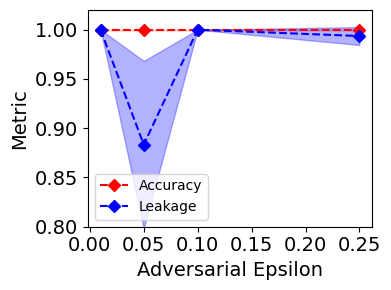

In [17]:
seeds = [42,43,44]

accuracy_values = []
leakage_values = []

for adversarial_epsilon in [0.01,0.05,0.1,0.25]:
    accuracy_values.append([])
    leakage_values.append([])
    for seed in seeds:
        result_name = get_name_matching_parameters({'train_variation': 'adversarial', 'adversarial_epsilon': adversarial_epsilon,'adversarial_weight': 0.25, 'seed': seed,'debugging': False})
        result_name = result_name[0]
        results_loc = '../../results/synthetic/{}/results.json'.format(result_name,seed)
        results = json.load(open(results_loc,"r"))
        
        leakage_values[-1].append(np.mean(results['adversarial_activations']))
        accuracy_values[-1].append(results['test_accuracy'])

accuracy_values = np.array(accuracy_values).T
leakage_values = np.array(leakage_values).T

mean_accuracy = np.mean(accuracy_values,axis=0)
std_accuracy = np.std(accuracy_values,axis=0)

mean_leakage = np.mean(leakage_values,axis=0)
std_leakage = np.std(leakage_values,axis=0)

x_vals = [0.01,0.05,0.1,0.25]

plt.figure(figsize=(4,3))

plt.fill_between(x_vals, mean_accuracy - std_accuracy, mean_accuracy + std_accuracy, alpha=0.3,  color='red')
plt.plot(x_vals, mean_accuracy, 'rD--',label='Accuracy')

plt.fill_between(x_vals, mean_leakage - std_leakage, mean_leakage + std_leakage, alpha=0.3,  color='blue')
plt.plot(x_vals, mean_leakage, 'bD--',label='Leakage')

# Add labels, legend, and title
plt.xlabel('Adversarial Epsilon',fontsize=14)
plt.ylabel('Metric',fontsize=14)
plt.ylim([0.8,1.02])
plt.legend() 
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.tight_layout()

plt.savefig("../../results/figures/half_loss.pdf",dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

### Synthetic Correlations

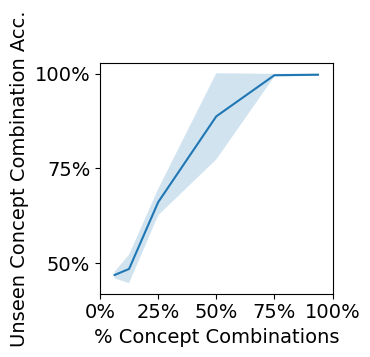

In [21]:
results = glob.glob("../../results/correlation/*.json")
all_json = [json.load(open(i)) for i in results]
keys = sorted(list(set([i['parameters']['num_concept_combinations'] for i in all_json])))
all_std = [np.std([i['out_distro'] for i in all_json if i['parameters']['num_concept_combinations'] == key]) for key in keys]
all_json = [np.mean([i['out_distro'] for i in all_json if i['parameters']['num_concept_combinations'] == key]) for key in keys]

all_json = np.array(all_json)
all_std = np.array(all_std)

plt.figure(figsize=(3,3))
plt.plot([key/16 for key in keys],all_json)
plt.yticks([0.5,0.75,1],["50%","75%","100%"],fontsize=14)
plt.xticks([0,0.25,0.5,0.75,1],["0%","25%","50%","75%","100%"],fontsize=14)
plt.xlim([0,1])
plt.ylabel("Unseen Concept Combination Acc.",fontsize=14)
plt.fill_between([key/16 for key in keys], all_json - all_std, all_json + all_std, alpha=0.2)

plt.xlabel("% Concept Combinations",fontsize=14)
plt.savefig("../../results/figures/correlations.pdf",dpi=300, bbox_inches='tight')


/usr0/home/naveenr/miniconda3/envs/concepts_spurious/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr0/home/naveenr/miniconda3/envs/concepts_spurious/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


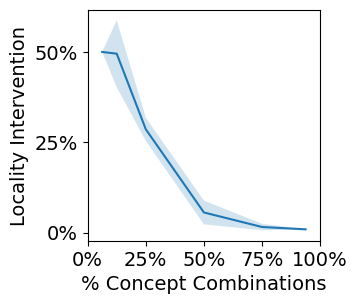

In [9]:
results = glob.glob("../../results/correlation/*.json")
all_json = [json.load(open(i)) for i in results]
keys = sorted(list(set([i['parameters']['num_concept_combinations'] for i in all_json])))
all_std = [np.std([np.mean(i['concept_accuracies']) for i in all_json if i['parameters']['num_concept_combinations'] == key and 'concept_accuracies' in i]) for key in keys]

all_json = [1-np.mean([np.mean(i['concept_accuracies']) for i in all_json if i['parameters']['num_concept_combinations'] == key  and 'concept_accuracies' in i]) for key in keys]
all_json = np.array(all_json)
all_std = np.array(all_std)

plt.figure(figsize=(3,3))
plt.plot([key/16 for key in keys],all_json)
plt.fill_between([key/16 for key in keys], all_json - all_std, all_json + all_std, alpha=0.2)
plt.yticks([0,0.25,0.5],["0%","25%","50%"],fontsize=14)
plt.xticks([0,0.25,0.5,0.75,1],["0%","25%","50%","75%","100%"],fontsize=14)
plt.ylabel("Locality Intervention",fontsize=14)
plt.xlabel("% Concept Combinations",fontsize=14)
plt.savefig("../../results/figures/correlations_flipped.pdf",dpi=300, bbox_inches='tight')


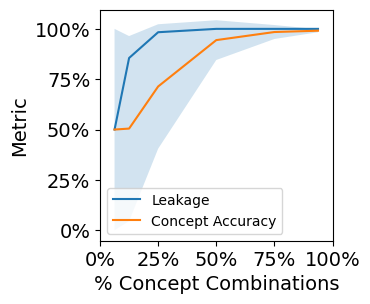

In [16]:
results = glob.glob("../../results/correlation/*.json")
all_json = [json.load(open(i)) for i in results]
keys = sorted(list(set([i['parameters']['num_concept_combinations'] for i in all_json])))
all_std = [np.std([i['adversarial_activations'] for i in all_json if i['parameters']['num_concept_combinations'] == key]) for key in keys]

all_json = [np.mean([i['adversarial_activations'] for i in all_json if i['parameters']['num_concept_combinations'] == key]) for key in keys]
all_json = np.array(all_json)
all_std = np.array(all_std)

plt.figure(figsize=(3,3))
plt.plot([key/16 for key in keys],all_json,label="Leakage")


all_json = [json.load(open(i)) for i in results]
all_std = [np.std([i['concept_accuracies'] for i in all_json if i['parameters']['num_concept_combinations'] == key]) for key in keys]
all_std = np.array(all_std)
all_json = [np.mean([i['concept_accuracies'] for i in all_json if i['parameters']['num_concept_combinations'] == key]) for key in keys]
all_json = np.array(all_json)
plt.plot([key/16 for key in keys],all_json,label="Concept Accuracy")


plt.fill_between([key/16 for key in keys], all_json - all_std, all_json + all_std, alpha=0.2)
plt.yticks([0,0.25,0.5,0.75,1],["0%","25%","50%","75%","100%"],fontsize=14)
plt.xticks([0,0.25,0.5,0.75,1],["0%","25%","50%","75%","100%"],fontsize=14)
plt.ylabel("Metric",fontsize=14)
plt.xlabel("% Concept Combinations",fontsize=14)
plt.legend()
plt.savefig("../../results/figures/avg_adversarial.pdf",dpi=300, bbox_inches='tight')


In [25]:
results_loc = '../../results/cub/mask_epsilon_42.json'
results = json.load(open(results_loc))
results

{'part_mask': {'back': {'back': [0.10884742438793182, 0.15051178634166718],
   'belly': [0.10457196831703186, 0.14536036550998688],
   'breast': [0.1116868108510971, 0.14789257943630219],
   'crown': [0.10511501878499985, 0.14209416508674622],
   'forehead': [0.10400591045618057, 0.14575861394405365],
   'nape': [0.12658533453941345, 0.16573068499565125],
   'tail': [0.042339351028203964, 0.0713697001338005],
   'throat': [0.14212395250797272, 0.18834160268306732]},
  'belly': {'back': [0.09879385679960251, 0.14672279357910156],
   'belly': [0.10829982161521912, 0.14903496205806732],
   'breast': [0.1350468397140503, 0.1852760761976242],
   'crown': [0.09144698828458786, 0.1169254332780838],
   'forehead': [0.1134055033326149, 0.16683846712112427],
   'nape': [0.11368812620639801, 0.1510857343673706],
   'tail': [0.05693461745977402, 0.09841934591531754],
   'throat': [0.12935511767864227, 0.16432785987854004]},
  'breast': {'back': [0.08917414397001266, 0.1376953125],
   'belly': [0.1

CUB 50 3
CUB 100 3
CUB 150 3
CUB 200 3
[0.1830172222496178, 0.18945759534835815, 0.13978439569473267, 0.13291402657826742, 0.12887253363927206]
coco 16 3
coco 32 3
coco 48 3
coco 64 3
[0.2046208530805687, 0.2199052373568217, 0.14020540316899618, 0.1189573605855306, 0.1013033390045166]


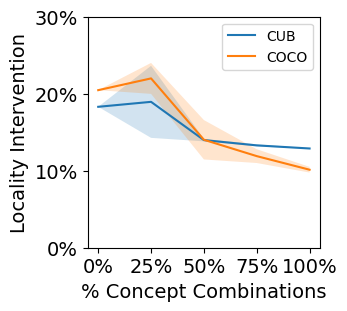

In [13]:
plt.figure(figsize=(3,3))

for dataset,concept_nums in zip(["CUB","coco"],[[0,50,100,150,200],[0,16,32,48,64]]):
    locality_levels = []
    stds = []
    for i in concept_nums:
        if i == 0:
            if dataset == 'CUB':
                locality_levels.append(0.1830172222496178)
                stds.append(0)
            else:
                locality_levels.append(0.2046208530805687)
                stds.append(0)
        else:
            results = get_name_matching_parameters({'dataset_name': dataset, 'num_concept_combinations': i},folder_name='results/correlation')
            all_results = []
            for a in results:
                all_results.append(json.load(open("../../results/correlation/{}.json".format(a)))['locality_intervention'])
            locality_levels.append(np.mean(all_results))
            stds.append(np.std(all_results))
            print(dataset,i,len(all_results))
    print(locality_levels)

    plt.plot([0,0.25,0.5,0.75,1],locality_levels,label=dataset.upper())
    plt.fill_between([0,0.25,0.5,0.75,1], np.array(locality_levels) - np.array(stds), np.array(locality_levels) + np.array(stds), alpha=0.2)
plt.yticks([0,0.1,0.2,0.3],["0%","10%","20%","30%"],fontsize=14)
plt.xticks([0,0.25,0.5,0.75,1],["0%","25%","50%","75%","100%"],fontsize=14)
plt.ylabel("Locality Intervention",fontsize=14)
plt.xlabel("% Concept Combinations",fontsize=14)
plt.legend()
plt.savefig("../../results/figures/cub_coco_intervention.pdf",dpi=300, bbox_inches='tight')



In [20]:
results = get_name_matching_parameters({'dataset_name': 'CUB', 'num_concept_combinations': 50},folder_name='results/correlation')


{'parameters': {'seed': 43,
  'encoder_model': 'inceptionv3',
  'debugging': False,
  'dataset_name': 'CUB',
  'num_concept_combinations': 50},
 'locality_intervention': 0.15436846017837524}

## CUB

In [9]:
def get_avg(results_by_part_mask):
    vals = []
    for i in results_by_part_mask:
        for j in results_by_part_mask[i]:
            if i!=j:
                vals.append(results_by_part_mask[i][j][0])
    return np.mean(vals) 

In [10]:
def get_avg_part_part(results_by_part_mask):
    vals = []
    for i in results_by_part_mask:
        for j in results_by_part_mask[i]:
            if i==j:
                vals.append(results_by_part_mask[i][j][0])
    return np.mean(vals) 

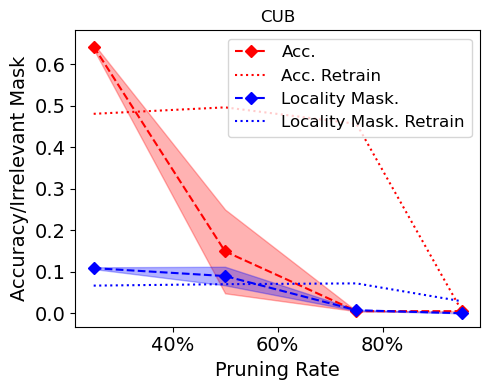

In [7]:
seeds = [42,43,44]

accuracy_values = []
leakage_values = []

accuracy_values_retrain = []
leakage_values_retrain = []


for pruning_rate in [0.25,0.5,0.75,0.95]:
    accuracy_values.append([])
    leakage_values.append([])

    accuracy_values_retrain.append([])
    leakage_values_retrain.append([])

    for seed in seeds:
        for retrain_epochs in [0,5]:
            result_name = get_name_matching_parameters({'seed': seed, 'prune_rate': pruning_rate, 'retrain_epochs': retrain_epochs},folder_name="results/cub_pruning")
            result_name = result_name[-1]
            results_loc = '../../results/cub_pruning/{}.json'.format(result_name,seed)
            results = json.load(open(results_loc,"r"))

            if retrain_epochs == 0:
                accuracy_values[-1].append(results['test_accuracy'])
                leakage_values[-1].append(get_avg(results['results_by_part_mask']))
            else:
                accuracy_values_retrain[-1].append(results['test_accuracy'])
                leakage_values_retrain[-1].append(get_avg(results['results_by_part_mask']))


accuracy_values = np.array(accuracy_values).T
leakage_values = np.array(leakage_values).T
accuracy_values_retrain = np.array(accuracy_values_retrain).T
leakage_values_retrain = np.array(leakage_values_retrain).T

mean_accuracy = np.mean(accuracy_values,axis=0)
std_accuracy = np.std(accuracy_values,axis=0)
mean_accuracy_retrain = np.mean(accuracy_values_retrain,axis=0)
std_accuracy_retrain = np.std(accuracy_values_retrain,axis=0)

mean_leakage = np.mean(leakage_values,axis=0)
std_leakage = np.std(leakage_values,axis=0)
mean_leakage_retrain = np.mean(leakage_values_retrain,axis=0)
std_leakage_retrain = np.std(leakage_values_retrain,axis=0)

x_vals = [0.25,0.5,0.75,0.95]

plt.figure(figsize=(5,4))

plt.fill_between(x_vals, mean_accuracy - std_accuracy, mean_accuracy + std_accuracy, alpha=0.3, color='red')
plt.plot(x_vals, mean_accuracy, 'rD--', label="Acc.")
plt.plot(x_vals, mean_accuracy_retrain, 'r:', label="Acc. Retrain")

plt.fill_between(x_vals, mean_leakage - std_leakage, mean_leakage + std_leakage, alpha=0.3, color='blue')
plt.plot(x_vals, mean_leakage, 'bD--', label="Locality Mask.")
plt.plot(x_vals, mean_leakage_retrain, 'b:', label="Locality Mask. Retrain")

# Add labels, legend, and title
plt.title("CUB")

plt.xlabel('Pruning Rate',fontsize=14)
plt.ylabel('Accuracy/Irrelevant Mask',fontsize=14)
plt.xticks([0.4,0.6,0.8],["40%","60%","80%"],fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12,loc='upper right') 
plt.tight_layout()

plt.savefig("../../results/figures/pruning_cub.pdf",dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

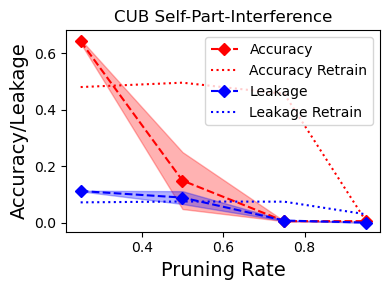

In [38]:
seeds = [42,43,44]

accuracy_values = []
leakage_values = []

accuracy_values_retrain = []
leakage_values_retrain = []


for pruning_rate in [0.25,0.5,0.75,0.95]:
    accuracy_values.append([])
    leakage_values.append([])

    accuracy_values_retrain.append([])
    leakage_values_retrain.append([])

    for seed in seeds:
        for retrain_epochs in [0,5]:
            result_name = get_name_matching_parameters({'seed': seed, 'prune_rate': pruning_rate, 'retrain_epochs': retrain_epochs},folder_name="results/cub_pruning")
            result_name = result_name[-1]
            results_loc = '../../results/cub_pruning/{}.json'.format(result_name,seed)
            results = json.load(open(results_loc,"r"))

            if retrain_epochs == 0:
                accuracy_values[-1].append(results['test_accuracy'])
                leakage_values[-1].append(get_avg_part_part(results['results_by_part_mask']))
            else:
                accuracy_values_retrain[-1].append(results['test_accuracy'])
                leakage_values_retrain[-1].append(get_avg_part_part(results['results_by_part_mask']))


accuracy_values = np.array(accuracy_values).T
leakage_values = np.array(leakage_values).T
accuracy_values_retrain = np.array(accuracy_values_retrain).T
leakage_values_retrain = np.array(leakage_values_retrain).T

mean_accuracy = np.mean(accuracy_values,axis=0)
std_accuracy = np.std(accuracy_values,axis=0)
mean_accuracy_retrain = np.mean(accuracy_values_retrain,axis=0)
std_accuracy_retrain = np.std(accuracy_values_retrain,axis=0)

mean_leakage = np.mean(leakage_values,axis=0)
std_leakage = np.std(leakage_values,axis=0)
mean_leakage_retrain = np.mean(leakage_values_retrain,axis=0)
std_leakage_retrain = np.std(leakage_values_retrain,axis=0)

x_vals = [0.25,0.5,0.75,0.95]

plt.figure(figsize=(4,3))

plt.fill_between(x_vals, mean_accuracy - std_accuracy, mean_accuracy + std_accuracy, alpha=0.3, color='red')
plt.plot(x_vals, mean_accuracy, 'rD--', label="Accuracy")
plt.plot(x_vals, mean_accuracy_retrain, 'r:', label="Accuracy Retrain")

plt.fill_between(x_vals, mean_leakage - std_leakage, mean_leakage + std_leakage, alpha=0.3, color='blue')
plt.plot(x_vals, mean_leakage, 'bD--', label="Leakage")
plt.plot(x_vals, mean_leakage_retrain, 'b:', label="Leakage Retrain")

plt.title("CUB Self-Part-Interference")
# Add labels, legend, and title
plt.xlabel('Pruning Rate',fontsize=14)
plt.ylabel('Accuracy/Leakage',fontsize=14)
plt.legend() 
plt.tight_layout()

# Show the plot
plt.show()

In [6]:
inference_by_part[0][1]

0.10173758616050084

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7


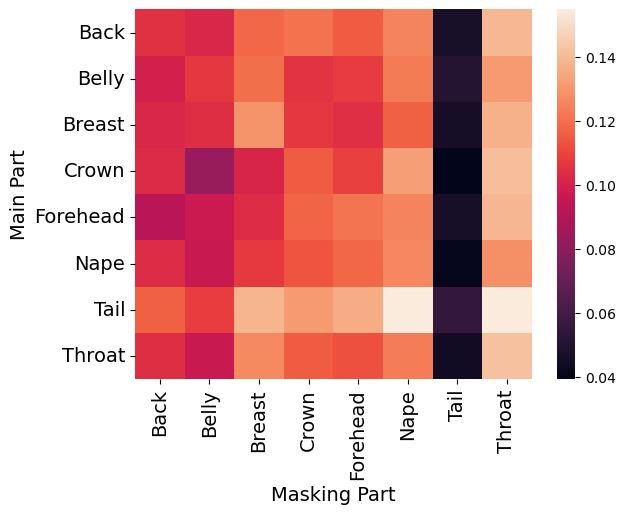

In [5]:
seeds = [42,43,44]

seed = 42
result_name = "../../results/cub/mask_epsilon_{}.json".format(seed)
results = json.load(open(result_name))
part_names = sorted(list(results['part_mask'].keys()))
inference_by_part = np.zeros((len(part_names),len(part_names)))
for seed in [42,43,44]:
    result_name = "../../results/cub/mask_epsilon_{}.json".format(seed)
    results = json.load(open(result_name))
    part_names_2 = sorted(results['part_mask'].keys())

    for i,p_1 in enumerate(part_names):
        for j,p_2 in enumerate(part_names):
            if p_2 in results['part_mask'][p_1]:
                print(i,j)
                inference_by_part[i,j] += results['part_mask'][p_1][p_2][0] 

inference_by_part /= len(seeds)
part_names_nice = [i.capitalize() for i in part_names]
sns.heatmap(inference_by_part,xticklabels=part_names_nice,yticklabels=part_names_nice)
plt.xlabel("Masking Part",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Main Part",fontsize=14)
plt.savefig("../../results/figures/cub_heatmap.pdf",dpi=300, bbox_inches='tight')


0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7


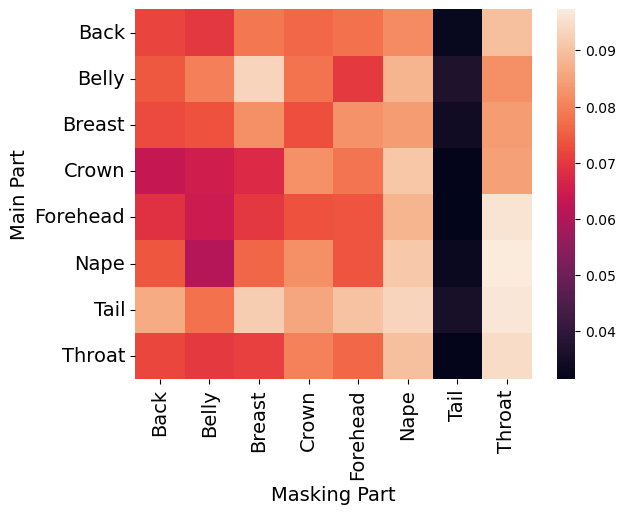

In [42]:
seeds = [42,43,44]

seed = 42
result_name = "../../results/cub/mask_epsilon_mean_color_{}.json".format(seed)
results = json.load(open(result_name))
part_names = sorted(list(results['part_mask'].keys()))
inference_by_part = np.zeros((len(part_names),len(part_names)))
for seed in [42,43,44]:
    result_name = "../../results/cub/mask_epsilon_mean_color_{}.json".format(seed)
    results = json.load(open(result_name))
    part_names_2 = sorted(results['part_mask'].keys())

    for i,p_1 in enumerate(part_names):
        for j,p_2 in enumerate(part_names):
            if p_2 in results['part_mask'][p_1]:
                print(i,j)
                inference_by_part[i,j] += results['part_mask'][p_1][p_2][0] 

inference_by_part /= len(seeds)
part_names_nice = [i.capitalize() for i in part_names]
sns.heatmap(inference_by_part,xticklabels=part_names_nice,yticklabels=part_names_nice)
plt.xlabel("Masking Part",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Main Part",fontsize=14)
plt.savefig("../../results/figures/cub_mean_heatmap.pdf",dpi=300, bbox_inches='tight')


#### Train Variations CUB

In [29]:
np.mean(relevant_variation,axis=0)[2]/np.mean(irrelevant_variation,axis=0)[2]

1.03470312065579

In [28]:
np.mean(relevant_variation,axis=0)[0]/np.mean(irrelevant_variation,axis=0)[0]

1.0473327234944922

/usr0/home/naveenr/miniconda3/envs/concepts_spurious/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator


<Figure size 200x300 with 0 Axes>

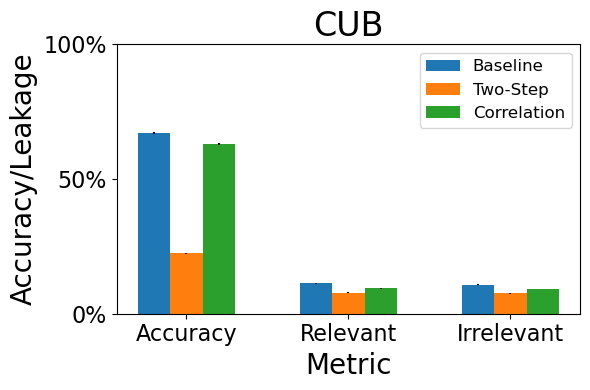

In [23]:
seeds = [42,43,44]

variation_list = ["none","loss","half"]
nice_name = ["Baseline","Two-Step","Correlation"]

accuracy_variation = []
relevant_variation = []
irrelevant_variation = []

for seed in seeds:
    accuracy_variation.append([])
    relevant_variation.append([])
    irrelevant_variation.append([])

    for variation in variation_list:
        if variation != "none":
            results_loc = '../../results/cub/mask_epsilon_{}_{}.json'.format(variation,seed)
        else:
            results_loc = '../../results/cub/mask_epsilon_{}.json'.format(seed)
        results = json.load(open(results_loc,"r"))

        if variation == 'label-free':
            results['test_acc'] = 0.7458

        accuracy_variation[-1].append(results['test_acc'])
        relevant_variation[-1].append(get_avg_part_part(results['part_mask']))
        irrelevant_variation[-1].append(get_avg(results['part_mask']))
    
accuracy_variation = np.array(accuracy_variation)
relevant_variation = np.array(relevant_variation)
irrelevant_variation = np.array(irrelevant_variation)

mean_accuracy = np.mean(accuracy_variation,axis=0)
mean_relevant = np.mean(relevant_variation,axis=0)
mean_irrelevant = np.mean(irrelevant_variation,axis=0)

std_accuracy = np.std(accuracy_variation,axis=0)
std_relevant = np.std(relevant_variation,axis=0)
std_irrelevant = np.std(irrelevant_variation,axis=0)

plt.figure(figsize=(2,3))

fig, ax = plt.subplots(figsize=(6,4))

# Set the x-ticks and labels
ind = np.arange(3)
ax.set_xticks(ind)
ax.set_xticklabels(["Accuracy","Relevant","Irrelevant"],fontsize=16)
ax.set_yticklabels(["0%","50%","100%"],fontsize=16)
ax.set_yticks([0,0.5,1])
ax.set_ylim([0,1])

# Set the y-axis label
ax.set_ylabel('Accuracy/Leakage',fontsize=20)
plt.xlabel("Metric",fontsize=20)

# Plot the bars with standard deviation error bars
width = 0.2
for i in range(len(mean_accuracy)):
    ax.bar(ind + (i-1)*width, [mean_accuracy[i],mean_relevant[i],mean_irrelevant[i]], width, yerr=[std_accuracy[i],std_relevant[i],std_irrelevant[i]], label=nice_name[i])


# plt.fill_between(x_vals, mean_accuracy - std_accuracy, mean_accuracy + std_accuracy, alpha=0.3, color='red')
# plt.plot(x_vals, mean_accuracy, 'rD--', label="Accuracy")
# plt.plot(x_vals, mean_accuracy_retrain, 'r:', label="Accuracy Retrain")

# plt.fill_between(x_vals, mean_leakage - std_leakage, mean_leakage + std_leakage, alpha=0.3, color='blue')
# plt.plot(x_vals, mean_leakage, 'bD--', label="Leakage")
# plt.plot(x_vals, mean_leakage_retrain, 'b:', label="Leakage Retrain")

plt.title("CUB",fontsize=24)
# # Add labels, legend, and title
# plt.xlabel('Pruning Rate',fontsize=14)
# plt.ylabel('Accuracy/Leakage',fontsize=14)
plt.legend(fontsize=12) 
plt.tight_layout()

plt.savefig("../../results/figures/train_variation_cub.pdf",dpi=300,bbox_inches='tight')

# Show the plot
plt.show()


In [12]:
seeds = [42,43,44]

variation_list = ["none","label-free","cub_cem","cub_probcbm","coco_none","coco_cem","coco_probcbm"]

accuracy_variation = []
relevant_variation = []
irrelevant_variation = []

for seed in seeds:
    accuracy_variation.append([])
    relevant_variation.append([])
    irrelevant_variation.append([])

    for variation in variation_list:
        if 'coco' in variation:
            variation = variation.split("_")
            if variation[1] == 'none':
                results_loc = '../../results/coco/mask_none_{}.json'.format(seed)
            else:
                results_loc = '../../results/{}/mask_{}_{}.json'.format(variation[0],variation[1],seed)
        elif 'cub' in variation: 
            variation = variation.split("_")
            results_loc = '../../results/cub/mask_epsilon_mean_color_{}_{}.json'.format(seed,variation[1])
        elif variation != "none":
            results_loc = '../../results/cub/mask_epsilon_{}_{}.json'.format(variation,seed)
        else:
            results_loc = '../../results/cub/mask_epsilon_{}.json'.format(seed)
        results = json.load(open(results_loc,"r"))

        if variation == 'label-free':
            results['test_acc'] = 0.7458

        accuracy_variation[-1].append(results['test_acc'])
        relevant_variation[-1].append(get_avg_part_part(results['part_mask']))
        irrelevant_variation[-1].append(get_avg(results['part_mask']))
    
accuracy_variation = np.array(accuracy_variation)
relevant_variation = np.array(relevant_variation)
irrelevant_variation = np.array(irrelevant_variation)

mean_accuracy = np.mean(accuracy_variation,axis=0)
mean_relevant = np.mean(relevant_variation,axis=0)
mean_irrelevant = np.mean(irrelevant_variation,axis=0)

std_accuracy = np.std(accuracy_variation,axis=0)
std_relevant = np.std(relevant_variation,axis=0)
std_irrelevant = np.std(irrelevant_variation,axis=0)

print(mean_accuracy)
print(mean_relevant-mean_irrelevant)

print(std_accuracy)
print(std_relevant+std_irrelevant)

latex_code = """CUB &      Baseline (7 Layer)  &    {}\\% $\\pm$ {}\\%      & -              &       {}  $\\pm$ {}   &       {}  $\\pm$ {}         \\\\
     &   Label-Free CBM     &  {}\\%  $\\pm$ {}\\%      & -                &        {}  $\\pm$ {}    &       {}  $\\pm$ {}       \\\\ 
     &   CEM    &   {}\\% $\\pm$ {}\\%      & -              &       {}  $\\pm$ {}   &       {}  $\\pm$ {}         \\\\ 
     &   ProbCBM     &   {}\\% $\\pm$ {}\\%      & -              &       {}  $\\pm$ {}   &       {}  $\\pm$ {}         \\\\ 
     COCO &      Baseline (7 Layer)  &    {}\\% $\\pm$ {}\\%      & -              &       {}  $\\pm$ {}   &       {}  $\\pm$ {}         \\\\
     &   CEM    &   {}\\% $\\pm$ {}\\%      & -              &       {}  $\\pm$ {}   &       {}  $\\pm$ {}         \\\\ 
     &   ProbCBM     &  {}\\% $\\pm$ {}\\%      & -              &       {}  $\\pm$ {}   &       {}  $\\pm$ {}         \\\\ \\bottomrule"""

latex_code = latex_code.format("{:.1f}".format(mean_accuracy[0]*100),"{:.1f}".format(std_accuracy[0]*100),
"{:.3f}".format((mean_relevant)[0]),"{:.3f}".format((std_relevant)[0]),
"{:.3f}".format((mean_irrelevant)[0]),"{:.3f}".format((std_irrelevant)[0]),
"{:.1f}".format(mean_accuracy[1]*100),"{:.1f}".format(std_accuracy[1]*100),
"{:.3f}".format((mean_relevant)[1]),"{:.3f}".format((std_relevant)[1]),
"{:.3f}".format((mean_irrelevant)[1]),"{:.3f}".format((std_irrelevant)[1]),
"{:.1f}".format(mean_accuracy[2]*100),"{:.1f}".format(std_accuracy[2]*100),
"{:.3f}".format((mean_relevant)[2]),"{:.3f}".format((std_relevant)[2]),
"{:.3f}".format((mean_irrelevant)[2]),"{:.3f}".format((std_irrelevant)[2]),
"{:.1f}".format(mean_accuracy[3]*100),"{:.1f}".format(std_accuracy[3]*100),
"{:.3f}".format((mean_relevant)[3]),"{:.3f}".format((std_relevant)[3]),
"{:.3f}".format((mean_irrelevant)[3]),"{:.3f}".format((std_irrelevant)[3]),
"{:.1f}".format(mean_accuracy[4]*100),"{:.1f}".format(std_accuracy[4]*100),
"{:.3f}".format((mean_relevant)[4]),"{:.3f}".format((std_relevant)[4]),
"{:.3f}".format((mean_irrelevant)[4]),"{:.3f}".format((std_irrelevant)[4]),
"{:.1f}".format(mean_accuracy[5]*100),"{:.1f}".format(std_accuracy[5]*100),
"{:.3f}".format((mean_relevant)[5]),"{:.3f}".format((std_relevant)[5]),
"{:.3f}".format((mean_irrelevant)[5]),"{:.3f}".format((std_irrelevant)[5]),
"{:.1f}".format(mean_accuracy[6]*100),"{:.1f}".format(std_accuracy[6]*100),
"{:.3f}".format((mean_relevant)[6]),"{:.3f}".format((std_relevant)[6]),
"{:.3f}".format((mean_irrelevant)[6]),"{:.3f}".format((std_irrelevant)[6]))
print(latex_code)


[0.67115407 0.7458     0.68145208 0.68191232 0.83886256 0.83609795
 0.83293839]
[0.00508716 0.0014797  0.00031765 0.00125471 0.04959858 0.00368894
 0.0156049 ]
[0.003654   0.         0.01028273 0.00778517 0.00335122 0.01065619
 0.00443324]
[0.00346547 0.00213219 0.00271685 0.00070273 0.01765157 0.02121974
 0.00410888]
CUB &      Baseline (7 Layer)  &    67.1\% $\pm$ 0.4\%      & -              &       0.113  $\pm$ 0.002   &       0.107  $\pm$ 0.002         \\
     &   Label-Free CBM     &  74.6\%  $\pm$ 0.0\%      & -                &        0.053  $\pm$ 0.001    &       0.052  $\pm$ 0.001       \\ 
     &   CEM    &   68.1\% $\pm$ 1.0\%      & -              &       0.035  $\pm$ 0.001   &       0.034  $\pm$ 0.001         \\ 
     &   ProbCBM     &   68.2\% $\pm$ 0.8\%      & -              &       0.008  $\pm$ 0.001   &       0.007  $\pm$ 0.000         \\ 
     COCO &      Baseline (7 Layer)  &    83.9\% $\pm$ 0.3\%      & -              &       0.144  $\pm$ 0.014   &       0.095  $\p

('0.001', '0.001')

In [ ]:
accuracy_variation

### CUB Masks

In [ ]:
Image.open("../../results/cub/mask_creation/example_0.05_44.png")

In [ ]:
Image.open("../../results/cub/mask_creation/example_0.15_44.png")

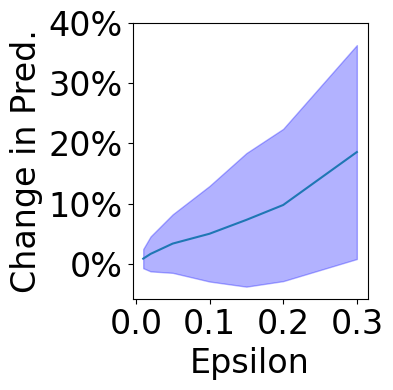

In [10]:
plt.figure(figsize=(4,4))
mask_results = [json.load(open("../../results/cub/mask_creation/mask_{}.json".format(seed))) for seed in [42,43,44]]
value_by_epsilon = []
std_by_epsilon = []
epsilon_values = sorted([float(i) for i in mask_results[0]['diff_by_epsilon'].keys()])

for ep in epsilon_values:
    value_by_epsilon.append(np.mean([i['diff_by_epsilon'][str(ep)][0] for i in mask_results]))
    std_by_epsilon.append(np.mean([i['diff_by_epsilon'][str(ep)][1] for i in mask_results]))
value_by_epsilon = np.array(value_by_epsilon)
std_by_epsilon = np.array(std_by_epsilon)
plt.plot(epsilon_values,value_by_epsilon)
plt.fill_between(epsilon_values, value_by_epsilon - std_by_epsilon, value_by_epsilon + std_by_epsilon, alpha=0.3, color='blue')
plt.xticks([0,0.1,0.2,0.3],fontsize=24)
plt.xlabel("Epsilon",fontsize=24)
plt.yticks([0,0.1,0.2,0.3,0.4],["0%","10%","20%","30%","40%"],fontsize=24)
plt.ylabel("Change in Pred.",fontsize=24)
plt.tight_layout()
plt.savefig("../../results/figures/masking_cub.pdf",dpi=300,bbox_inches='tight')

## Coco

In [76]:
def get_avg(results_by_part_mask):
    vals = []
    for i in results_by_part_mask:
        for j in results_by_part_mask[i]:
            if i!=j:
                vals.append(results_by_part_mask[i][j][0])
    return np.mean(vals) 

In [77]:
def get_avg_part_part(results_by_part_mask):
    vals = []
    for i in results_by_part_mask:
        for j in results_by_part_mask[i]:
            if i==j:
                vals.append(results_by_part_mask[i][j][0])
    return np.mean(vals) 

In [22]:
seeds = [42,43,44]

seed = 42
result_name = "../../results/coco/mask_none_{}.json".format(seed)
results = json.load(open(result_name))
part_names = sorted(results['part_mask'].keys())
train_locations = json.load(open(dataset_directory+"/coco/preprocessed/instances_train2014.json"))['categories']
concept_names = [[j['name'] for j in train_locations if j['id'] == int(i) ][0] for i in part_names]
inference_by_part = np.zeros((len(part_names),len(part_names)))

for seed in [42,43,44]:
    result_name = "../../results/coco/mask_none_{}.json".format(seed)
    results = json.load(open(result_name))
    part_names = sorted(results['part_mask'].keys())

    for i,p_1 in enumerate(part_names):
        for j,p_2 in enumerate(part_names):
            if p_2 in results['part_mask'][p_1]:
                inference_by_part[i,j] += results['part_mask'][p_1][p_2][0] 

inference_by_part /= len(seeds)
part_names_nice = [i.capitalize() for i in concept_names]
sns.heatmap(inference_by_part,xticklabels=part_names_nice,yticklabels=part_names_nice)
plt.xlabel("Masking Part",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Main Part",fontsize=14)

KeyboardInterrupt: 

In [32]:
np.mean(relevant_variation,axis=0)[2]/np.mean(irrelevant_variation,axis=0)[2]

1.541509763985752

In [31]:
np.mean(relevant_variation,axis=0)[0]/np.mean(irrelevant_variation,axis=0)[0]

1.5233694945866596

/usr0/home/naveenr/miniconda3/envs/concepts_spurious/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator


<Figure size 200x300 with 0 Axes>

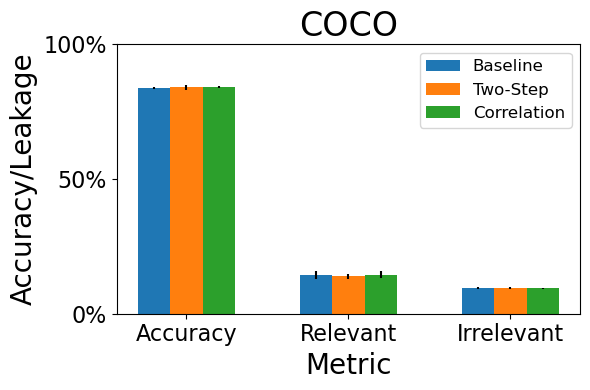

In [30]:
seeds = [42,43,44]

variation_list = ["none","loss","half"]
nice_name = ["Baseline","Two-Step","Correlation"]

accuracy_variation = []
relevant_variation = []
irrelevant_variation = []

for seed in seeds:
    accuracy_variation.append([])
    relevant_variation.append([])
    irrelevant_variation.append([])

    for variation in variation_list:
        results_loc = '../../results/coco/mask_{}_{}.json'.format(variation,seed)
        results = json.load(open(results_loc,"r"))

        accuracy_variation[-1].append(results['test_acc'])
        relevant_variation[-1].append(get_avg_part_part(results['part_mask']))
        irrelevant_variation[-1].append(get_avg(results['part_mask']))
    
accuracy_variation = np.array(accuracy_variation)
relevant_variation = np.array(relevant_variation)
irrelevant_variation = np.array(irrelevant_variation)

mean_accuracy = np.mean(accuracy_variation,axis=0)
mean_relevant = np.mean(relevant_variation,axis=0)
mean_irrelevant = np.mean(irrelevant_variation,axis=0)

std_accuracy = np.std(accuracy_variation,axis=0)
std_relevant = np.std(relevant_variation,axis=0)
std_irrelevant = np.std(irrelevant_variation,axis=0)

plt.figure(figsize=(2,3))

fig, ax = plt.subplots(figsize=(6,4))

# Set the x-ticks and labels
ind = np.arange(3)
ax.set_xticks(ind)
ax.set_xticklabels(["Accuracy","Relevant","Irrelevant"],fontsize=16)
ax.set_yticklabels(["0%","50%","100%"],fontsize=16)
ax.set_yticks([0,0.5,1])
ax.set_ylim([0,1])

# Set the y-axis label
ax.set_ylabel('Accuracy/Leakage',fontsize=20)
plt.xlabel("Metric",fontsize=20)

# Plot the bars with standard deviation error bars
width = 0.2
for i in range(len(mean_accuracy)):
    ax.bar(ind + (i-1)*width, [mean_accuracy[i],mean_relevant[i],mean_irrelevant[i]], width, yerr=[std_accuracy[i],std_relevant[i],std_irrelevant[i]], label=nice_name[i])


# plt.fill_between(x_vals, mean_accuracy - std_accuracy, mean_accuracy + std_accuracy, alpha=0.3, color='red')
# plt.plot(x_vals, mean_accuracy, 'rD--', label="Accuracy")
# plt.plot(x_vals, mean_accuracy_retrain, 'r:', label="Accuracy Retrain")

# plt.fill_between(x_vals, mean_leakage - std_leakage, mean_leakage + std_leakage, alpha=0.3, color='blue')
# plt.plot(x_vals, mean_leakage, 'bD--', label="Leakage")
# plt.plot(x_vals, mean_leakage_retrain, 'b:', label="Leakage Retrain")

plt.title("COCO",fontsize=24)
# # Add labels, legend, and title
# plt.xlabel('Pruning Rate',fontsize=14)
# plt.ylabel('Accuracy/Leakage',fontsize=14)
plt.legend(fontsize=12) 
plt.tight_layout()

plt.savefig("../../results/figures/train_variation_coco.pdf",dpi=300,bbox_inches='tight')

# Show the plot
plt.show()


In [20]:
mean_relevant/mean_irrelevant

array([1.04733272, 1.52336949])

/usr0/home/naveenr/miniconda3/envs/concepts_spurious/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator


<Figure size 400x300 with 0 Axes>

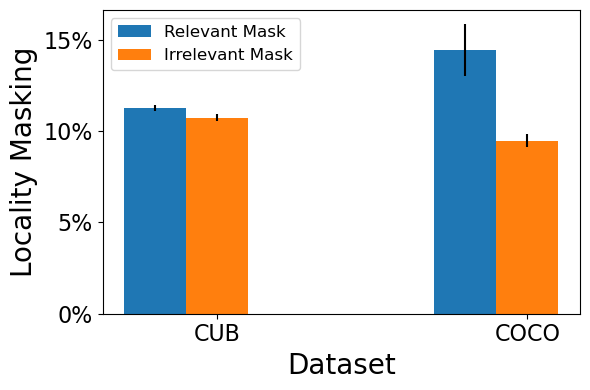

In [17]:
seeds = [42,43,44]

datasets = ["cub","coco"]
nice_name = ["CUB","Coco"]
irrelevant_mask = []
relevant_mask = []

for seed in seeds:
    irrelevant_mask.append([])
    relevant_mask.append([])
    for dataset in datasets:
        if dataset == "cub":
            results_loc = '../../results/cub/mask_epsilon_{}.json'.format(seed)
        elif dataset == "coco":
            results_loc = '../../results/coco/mask_none_{}.json'.format(seed)
        results = json.load(open(results_loc,"r"))

        irrelevant_mask[-1].append(get_avg(results['part_mask']))
        relevant_mask[-1].append(get_avg_part_part(results['part_mask']))


irrelevant_mask = np.array(irrelevant_mask)
relevant_mask = np.array(relevant_mask)

mean_irrelevant = np.mean(irrelevant_mask,axis=0)
std_irrelevant = np.std(irrelevant_mask,axis=0)

mean_relevant = np.mean(relevant_mask,axis=0)
std_relevant = np.std(relevant_mask,axis=0)

plt.figure(figsize=(4,3))

fig, ax = plt.subplots(figsize=(6,4))

# Set the x-ticks and labels
ind = np.arange(2)
ax.set_xticks(ind)
ax.set_xticklabels(["CUB","COCO"],fontsize=16)
ax.set_yticklabels(["0%","5%","10%","15%"],fontsize=16)
ax.set_yticks([0,0.05,0.1,0.15])

# Set the y-axis label
ax.set_ylabel('Locality Masking',fontsize=20)
plt.xlabel("Dataset",fontsize=20)

# Plot the bars with standard deviation error bars
width = 0.2
for i in range(2):
    if i == 0:
        vals = mean_relevant
        std = std_relevant
        label = "Relevant Mask"
    else:
        vals = mean_irrelevant
        std = std_irrelevant
        label = "Irrelevant Mask"
    ax.bar(ind + (i-1)*width, vals, width, label=label,yerr=std)

plt.legend(fontsize=12) 
plt.tight_layout()

plt.savefig("../../results/figures/coco_cub_leakage.pdf",dpi=300,bbox_inches='tight')

# Show the plot
plt.show()

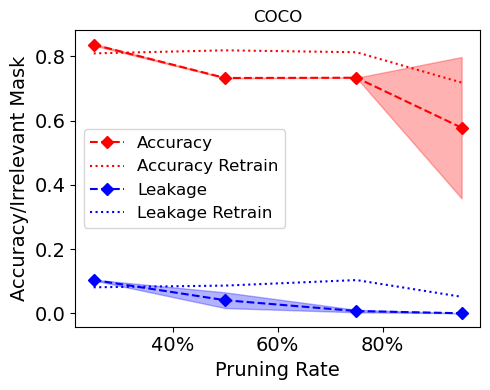

In [66]:
seeds = [42,43,44]

accuracy_values = []
leakage_values = []

accuracy_values_retrain = []
leakage_values_retrain = []


for pruning_rate in [0.25,0.5,0.75,0.95]:
    accuracy_values.append([])
    leakage_values.append([])

    accuracy_values_retrain.append([])
    leakage_values_retrain.append([])

    for seed in seeds:
        for retrain_epochs in [0,5]:
            result_name = get_name_matching_parameters({'seed': seed, 'prune_rate': pruning_rate, 'retrain_epochs': retrain_epochs},folder_name="results/coco_pruning")
            result_name = result_name[-1]
            results_loc = '../../results/coco_pruning/{}.json'.format(result_name,seed)
            results = json.load(open(results_loc,"r"))

            if retrain_epochs == 0:
                accuracy_values[-1].append(results['test_accuracy'])
                leakage_values[-1].append(get_avg(results['results_by_part_mask']))
            else:
                accuracy_values_retrain[-1].append(results['test_accuracy'])
                leakage_values_retrain[-1].append(get_avg(results['results_by_part_mask']))


accuracy_values = np.array(accuracy_values).T
leakage_values = np.array(leakage_values).T
accuracy_values_retrain = np.array(accuracy_values_retrain).T
leakage_values_retrain = np.array(leakage_values_retrain).T

mean_accuracy = np.mean(accuracy_values,axis=0)
std_accuracy = np.std(accuracy_values,axis=0)
mean_accuracy_retrain = np.mean(accuracy_values_retrain,axis=0)
std_accuracy_retrain = np.std(accuracy_values_retrain,axis=0)

mean_leakage = np.mean(leakage_values,axis=0)
std_leakage = np.std(leakage_values,axis=0)
mean_leakage_retrain = np.mean(leakage_values_retrain,axis=0)
std_leakage_retrain = np.std(leakage_values_retrain,axis=0)

x_vals = [0.25,0.5,0.75,0.95]

plt.figure(figsize=(5,4))
plt.title("COCO")


plt.fill_between(x_vals, mean_accuracy - std_accuracy, mean_accuracy + std_accuracy, alpha=0.3, color='red')
plt.plot(x_vals, mean_accuracy, 'rD--', label="Accuracy")
plt.plot(x_vals, mean_accuracy_retrain, 'r:', label="Accuracy Retrain")

plt.fill_between(x_vals, mean_leakage - std_leakage, mean_leakage + std_leakage, alpha=0.3, color='blue')
plt.plot(x_vals, mean_leakage, 'bD--', label="Leakage")
plt.plot(x_vals, mean_leakage_retrain, 'b:', label="Leakage Retrain")

# Add labels, legend, and title
plt.xlabel('Pruning Rate',fontsize=14)
plt.ylabel('Accuracy/Irrelevant Mask',fontsize=14)
plt.xticks([0.4,0.6,0.8],["40%","60%","80%"],fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12,loc='center left') 
plt.tight_layout()

plt.savefig("../../results/figures/pruning_coco.pdf",dpi=300, bbox_inches='tight')


# Show the plot
plt.show()

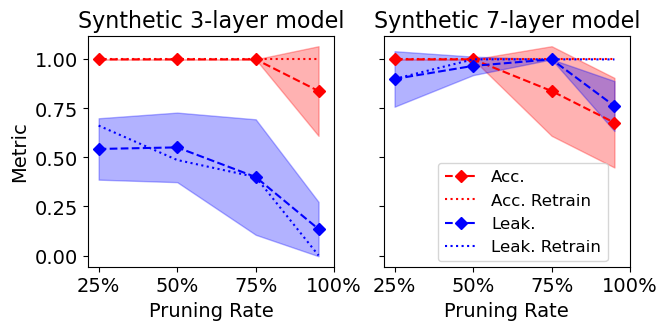

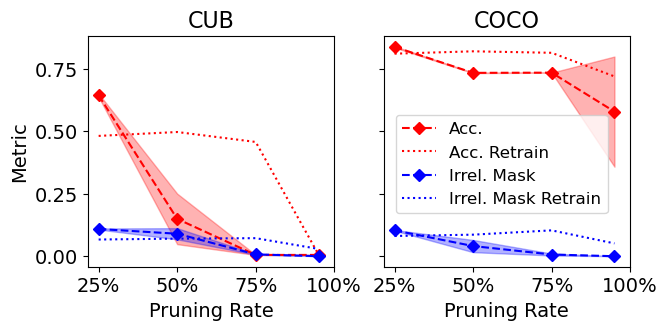

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3), sharey=True)

seeds = [42,43,44]
num_layers = 1

for i,encoder_model in enumerate(['small3','small7']):
    accuracy_values = []
    leakage_values = []

    accuracy_values_retrain = []
    leakage_values_retrain = []


    for pruning_rate in [0.25,0.5,0.75,0.95]:
        accuracy_values.append([])
        leakage_values.append([])

        accuracy_values_retrain.append([])
        leakage_values_retrain.append([])

        for seed in seeds:
            for retrain_epochs in [0,5]:
                # TODO: Fix this, double parameters
                result_name = get_name_matching_parameters({'dataset_name': 'synthetic_object/synthetic_1', 'encoder_model': encoder_model,'seed': seed, 'prune_rate': pruning_rate, 'retrain_epochs': retrain_epochs},folder_name="results/pruning")
                result_name = result_name[0]
                results_loc = '../../results/pruning/{}.json'.format(result_name,seed)
                results = json.load(open(results_loc,"r"))

                if retrain_epochs == 0:
                    accuracy_values[-1].append(results['test_accuracy'])
                    leakage_values[-1].append(np.mean(results['adversarial_activations']))
                else:
                    accuracy_values_retrain[-1].append(results['test_accuracy'])
                    leakage_values_retrain[-1].append(np.mean(results['adversarial_activations']))


    accuracy_values = np.array(accuracy_values).T
    leakage_values = np.array(leakage_values).T
    accuracy_values_retrain = np.array(accuracy_values_retrain).T
    leakage_values_retrain = np.array(leakage_values_retrain).T

    mean_accuracy = np.mean(accuracy_values,axis=0)
    std_accuracy = np.std(accuracy_values,axis=0)
    mean_accuracy_retrain = np.mean(accuracy_values_retrain,axis=0)
    std_accuracy_retrain = np.std(accuracy_values_retrain,axis=0)

    mean_leakage = np.mean(leakage_values,axis=0)
    std_leakage = np.std(leakage_values,axis=0)
    mean_leakage_retrain = np.mean(leakage_values_retrain,axis=0)
    std_leakage_retrain = np.std(leakage_values_retrain,axis=0)

    x_vals = [0.25,0.5,0.75,0.95]


    axes[i].fill_between(x_vals, mean_accuracy - std_accuracy, mean_accuracy + std_accuracy, alpha=0.3, color='red')
    axes[i].plot(x_vals, mean_accuracy, 'rD--', label="Acc.")
    axes[i].plot(x_vals, mean_accuracy_retrain, 'r:', label="Acc. Retrain")

    axes[i].fill_between(x_vals, mean_leakage - std_leakage, mean_leakage + std_leakage, alpha=0.3, color='blue')
    axes[i].plot(x_vals, mean_leakage, 'bD--', label="Leak.")
    axes[i].plot(x_vals, mean_leakage_retrain, 'b:', label="Leak. Retrain")

    axes[i].set_title("Synthetic {}-layer model".format(encoder_model.replace("small","")),fontsize=16)
    # Add labels, legend, and title
    axes[i].set_xlabel('Pruning Rate',fontsize=14)
    axes[i].set_xticks([0.25,0.5,0.75,1],["25%","50%","75%","100%"],fontsize=14)
    if i == 0:
        axes[i].set_ylabel('Metric',fontsize=14)
        axes[i].tick_params(axis='y', labelsize=14)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(),fontsize=12,loc='lower right', bbox_to_anchor=(0.88, 0.1))
plt.savefig("../../results/figures/combined_pruning_synthetic.pdf",dpi=300, bbox_inches='tight')


fig, axes = plt.subplots(1, 2, figsize=(7, 3), sharey=True)

seeds = [42,43,44]

accuracy_values = []
leakage_values = []

accuracy_values_retrain = []
leakage_values_retrain = []


for pruning_rate in [0.25,0.5,0.75,0.95]:
    accuracy_values.append([])
    leakage_values.append([])

    accuracy_values_retrain.append([])
    leakage_values_retrain.append([])

    for seed in seeds:
        for retrain_epochs in [0,5]:
            result_name = get_name_matching_parameters({'seed': seed, 'prune_rate': pruning_rate, 'retrain_epochs': retrain_epochs},folder_name="results/cub_pruning")
            result_name = result_name[-1]
            results_loc = '../../results/cub_pruning/{}.json'.format(result_name,seed)
            results = json.load(open(results_loc,"r"))

            if retrain_epochs == 0:
                accuracy_values[-1].append(results['test_accuracy'])
                leakage_values[-1].append(get_avg(results['results_by_part_mask']))
            else:
                accuracy_values_retrain[-1].append(results['test_accuracy'])
                leakage_values_retrain[-1].append(get_avg(results['results_by_part_mask']))


accuracy_values = np.array(accuracy_values).T
leakage_values = np.array(leakage_values).T
accuracy_values_retrain = np.array(accuracy_values_retrain).T
leakage_values_retrain = np.array(leakage_values_retrain).T

mean_accuracy = np.mean(accuracy_values,axis=0)
std_accuracy = np.std(accuracy_values,axis=0)
mean_accuracy_retrain = np.mean(accuracy_values_retrain,axis=0)
std_accuracy_retrain = np.std(accuracy_values_retrain,axis=0)

mean_leakage = np.mean(leakage_values,axis=0)
std_leakage = np.std(leakage_values,axis=0)
mean_leakage_retrain = np.mean(leakage_values_retrain,axis=0)
std_leakage_retrain = np.std(leakage_values_retrain,axis=0)

x_vals = [0.25,0.5,0.75,0.95]

axes[0].fill_between(x_vals, mean_accuracy - std_accuracy, mean_accuracy + std_accuracy, alpha=0.3, color='red')
axes[0].plot(x_vals, mean_accuracy, 'rD--', label="Acc.")
axes[0].plot(x_vals, mean_accuracy_retrain, 'r:', label="Acc. Retrain")

axes[0].fill_between(x_vals, mean_leakage - std_leakage, mean_leakage + std_leakage, alpha=0.3, color='blue')
axes[0].plot(x_vals, mean_leakage, 'bD--', label="Irrelevant Mask")
axes[0].plot(x_vals, mean_leakage_retrain, 'b:', label="Irrelevant Mask Retrain")

# Add labels, legend, and title
axes[0].set_title("CUB",fontsize=16)

axes[0].set_xlabel('Pruning Rate',fontsize=14)
axes[0].set_ylabel('Metric',fontsize=14)
axes[0].set_xticks([0.25,0.5,0.75,1],["25%","50%","75%","100%"],fontsize=14)
axes[0].set_yticks([0.00,0.25,0.5,0.75,1.00],fontsize=14)
axes[0].tick_params(axis='y', labelsize=14)

seeds = [42,43,44]

accuracy_values = []
leakage_values = []

accuracy_values_retrain = []
leakage_values_retrain = []


for pruning_rate in [0.25,0.5,0.75,0.95]:
    accuracy_values.append([])
    leakage_values.append([])

    accuracy_values_retrain.append([])
    leakage_values_retrain.append([])

    for seed in seeds:
        for retrain_epochs in [0,5]:
            result_name = get_name_matching_parameters({'seed': seed, 'prune_rate': pruning_rate, 'retrain_epochs': retrain_epochs},folder_name="results/coco_pruning")
            result_name = result_name[-1]
            results_loc = '../../results/coco_pruning/{}.json'.format(result_name,seed)
            results = json.load(open(results_loc,"r"))

            if retrain_epochs == 0:
                accuracy_values[-1].append(results['test_accuracy'])
                leakage_values[-1].append(get_avg(results['results_by_part_mask']))
            else:
                accuracy_values_retrain[-1].append(results['test_accuracy'])
                leakage_values_retrain[-1].append(get_avg(results['results_by_part_mask']))


accuracy_values = np.array(accuracy_values).T
leakage_values = np.array(leakage_values).T
accuracy_values_retrain = np.array(accuracy_values_retrain).T
leakage_values_retrain = np.array(leakage_values_retrain).T

mean_accuracy = np.mean(accuracy_values,axis=0)
std_accuracy = np.std(accuracy_values,axis=0)
mean_accuracy_retrain = np.mean(accuracy_values_retrain,axis=0)
std_accuracy_retrain = np.std(accuracy_values_retrain,axis=0)

mean_leakage = np.mean(leakage_values,axis=0)
std_leakage = np.std(leakage_values,axis=0)
mean_leakage_retrain = np.mean(leakage_values_retrain,axis=0)
std_leakage_retrain = np.std(leakage_values_retrain,axis=0)

x_vals = [0.25,0.5,0.75,0.95]

axes[1].set_title("COCO",fontsize=16)


axes[1].fill_between(x_vals, mean_accuracy - std_accuracy, mean_accuracy + std_accuracy, alpha=0.3, color='red')
axes[1].plot(x_vals, mean_accuracy, 'rD--', label="Acc.")
axes[1].plot(x_vals, mean_accuracy_retrain, 'r:', label="Acc. Retrain")

axes[1].fill_between(x_vals, mean_leakage - std_leakage, mean_leakage + std_leakage, alpha=0.3, color='blue')
axes[1].plot(x_vals, mean_leakage, 'bD--', label="Irrel. Mask")
axes[1].plot(x_vals, mean_leakage_retrain, 'b:', label="Irrel. Mask Retrain")

# Add labels, legend, and title
axes[1].set_xlabel('Pruning Rate',fontsize=14)
axes[1].set_xticks([0.25,0.5,0.75,1],["25%","50%","75%","100%"],fontsize=14)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(),fontsize=12,loc='lower right', bbox_to_anchor=(0.88, 0.26))

plt.savefig("../../results/figures/pruning_non_synthetic.pdf",dpi=300, bbox_inches='tight')


## DSprites 

In [ ]:
sns.reset_orig()
all_our_distance = []
all_ground_truth = []

concept_names = [
    "is_white",
    "is_square",
    "is_ellipse",
    "is_heart",
    "is_scale_0.5",
    "is_scale_0.6",
    "is_scale_0.7",
    "is_scale_0.8",
    "is_scale_0.9",
    "is_scale_1",
    "is_orientation_0",
    "is_orientation_90",
    "is_orientation_180",
    "is_orientation_270",
    "is_x_0",
    "is_x_16",
    "is_y_0",
    "is_y_16",
] 

for seed in [42,43,44]:
    predictions = json.load(open('results/dsprites/dsprites_20_predictions_{}.json'.format(seed),'r'))
    all_predictions = predictions['our_predictions']
    present_concept_combo = predictions['train_concepts']
    correct_answers = predictions['ground_truths']
    extra_predictions = predictions['predictions_raw']

    our_distance_freq = []
    ground_truth_distance_freq = []


    for i,pred in enumerate(all_predictions):
        distances = [hamming_distance(all_predictions[i],j) for j in present_concept_combo]
        min_distance = np.min(distances)
        our_distance_freq.append(min_distance)

    for i,pred in enumerate(correct_answers):
        distances = [hamming_distance(correct_answers[i],j) for j in present_concept_combo]
        min_distance = np.min(distances)
        ground_truth_distance_freq.append(min_distance)
    ground_truth_distance_freq = Counter(ground_truth_distance_freq)
    our_distance_freq = Counter(our_distance_freq)

    for i in our_distance_freq:
        if i not in ground_truth_distance_freq:
            ground_truth_distance_freq[i] = 0

    all_our_distance.append([our_distance_freq[i] for i in range(5)])
    all_ground_truth.append([ground_truth_distance_freq[i] for i in range(5)])

all_our_distance = np.array(all_our_distance)
all_ground_truth = np.array(all_ground_truth)

labels = [0, 1, 2, 3, 4]

# Set the width of the bars
bar_width = 0.35

# Calculate the x-coordinates for the bars
x = np.arange(len(labels))

# Create a figure and axis for the bar graph
fig, ax = plt.subplots(figsize=(5,5))

ground_truth_mean = np.mean(all_ground_truth,axis=0)
ground_truth_std = np.std(all_ground_truth,axis=0)

our_distance_mean =  np.mean(all_our_distance,axis=0)
our_distance_std = np.std(all_our_distance,axis=0)

# Create blue bars for ground_truth_distance_freq (or 0 if not present)
ax.bar(x - bar_width/2, ground_truth_mean, bar_width, yerr=ground_truth_std, color='blue', label='Ground Truth Label')

# Create yellow bars for our_distance_freq (or 0 if not present)
ax.bar(x + bar_width/2, our_distance_mean, bar_width, yerr=our_distance_std,color='red', label='Predicted Label', alpha=0.7)

# Set labels and title
ax.set_xlabel('Hamming Distance from Closest Training Point',fontsize=14)
ax.set_ylabel('Frequency',fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(labels,fontsize=14)
ax.set_yticks([0,50,100,150])
ax.set_yticklabels([0,50,100,150],fontsize=14)
ax.legend(fontsize='14')

# Show the plot
plt.tight_layout()
plt.savefig("results/figures/dsprites_distance_bar.pdf",dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
pca_dict = json.load(open('results/dsprites/pca_images.json','r'))
pca_images = np.array(pca_dict['pca_images'])
image_similarities = np.array(pca_dict['image_similarities'])
svm_accuracies = np.array(pca_dict['svm_accuracies'])

predictions = json.load(open('results/dsprites/dsprites_20_predictions.json','r'))
all_predictions = predictions['our_predictions']
present_concept_combo = predictions['train_concepts']
correct_answers = predictions['ground_truths']
attributes_as_matrix = np.array([[int(j) for j in i] for i in correct_answers])


for attribute in ['is_x_16','is_heart']:
    i = concept_names.index(attribute)
    first_attribute = attributes_as_matrix[:, i]

    attribute_to_title = {
        'is_x_16': 'Object Right Half',
        'is_heart': 'Heart Shaped'
    }

    # Create a scatter plot and color by the first attribute
    plt.figure(figsize=(5,3))
    plt.scatter(pca_images[:, 0], pca_images[:, 1], c=first_attribute, cmap='viridis')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title(attribute_to_title[attribute])
    plt.colorbar(label='Concept Label')
    plt.tight_layout() 

    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.savefig("results/figures/{}_pca.pdf".format(attribute),dpi=300, bbox_inches='tight')
    plt.show()

    plt.figure()


In [ ]:
results = json.load(open('results/dsprites/dsprites_20_results_42.json'))
pca_dict = json.load(open('results/dsprites/pca_images.json','r'))
svm_accuracies = np.array(pca_dict['svm_accuracies'])


X = svm_accuracies
y = [1-results[i]['freq_with_concept_adversarial'][0]/results[i]['freq_with_concept_adversarial'][1] for i in concept_names]

plt.figure(figsize=(3,3))
plt.xlabel("Concept Accuracy",fontsize=14)
plt.ylabel("Generalization Accuracy",fontsize=14)
xtick_labels = ['60%', '80%','100%']
plt.xticks([0.6,0.8,1], xtick_labels,fontsize=12)
plt.yticks([0,0.2,0.4,0.6,0.8,1.0],['0%','20%','40%','60%','80%','100%'],fontsize=12)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.scatter(x=X,y=y)
plt.savefig("results/figures/adversarial_scatter.pdf",dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
min(y)

## CUB

In [ ]:
targeted_mask_list = [json.load(open("results/cub/mask_epsilon_{}.json".format(seed),"r")) for seed in [42,43,44]]
random_mask_list = [json.load(open("results/cub/mask_random_{}.json".format(seed),"r")) for seed in [42,43,44]]
closest_mask_list = [json.load(open("results/cub/mask_closest_{}.json".format(seed),"r")) for seed in [42,43,44]]

target_y = [[] for i in range(5)]
random_y = [[] for i in range(5)]
closest_y = [[] for i in range(5)]
for part in targeted_mask_list[0]['mean']:
    for i,epsilon in enumerate(targeted_mask_list[0]['mean'][part]):
        for seed_num in range(3):
            target_val = round(targeted_mask_list[seed_num]['mean'][part][epsilon],2)
            random_val = round(random_mask_list[seed_num]['mean'][part][epsilon],2)
            closest_val = round(closest_mask_list[seed_num]['mean'][part][epsilon],2)

            target_y[i].append(target_val)
            random_y[i].append(random_val) 
            closest_y[i].append(closest_val)

x_values = list(range(len(target_y)))

# Calculate means and standard deviations
target_mean = np.mean(target_y, axis=1)
random_mean = np.mean(random_y, axis=1)
closest_mean = np.mean(closest_y, axis=1)

target_std = np.std(target_y, axis=1)
random_std = np.std(random_y, axis=1)
closest_std = np.std(closest_y, axis=1)

# Create the plot
# sns.set(style="whitegrid")
plt.figure(figsize=(5,3))

plt.yticks([0,0.2,0.4,0.6,0.8],["0%","20%","40%","60%","80%"],fontsize=14)
plt.xticks([0,1,2,3,4],["10","20","30","40","50"],fontsize=14)
plt.xlabel("Epsilon ($\epsilon$)",fontsize=14)
plt.ylabel("Concept Pred. Diff.",fontsize=14)


# Line plots with standard deviations and custom labels
plt.plot(x_values, target_mean, label='Full', color='blue')
plt.fill_between(x_values, target_mean - target_std, target_mean + target_std, color='blue', alpha=0.2)

plt.plot(x_values, random_mean, label='Random', color='orange')
plt.fill_between(x_values, random_mean - random_std, random_mean + random_std, color='orange', alpha=0.2)

plt.plot(x_values, closest_mean, label='Closest', color='green')
plt.fill_between(x_values, closest_mean - closest_std, closest_mean + closest_std, color='green', alpha=0.2)
plt.legend(fontsize="14")
plt.savefig("results/figures/cub_epsilon.pdf",dpi=300, bbox_inches='tight')
plt.show()

# Other Plots

## Synthetic Dataset Exploration

In [ ]:
for num_objects in [1,2,4]:
    file_loc = "results/synthetic/objects={}_noisy=False_wd=0.0004_model=small3_optimizer=sgd_seed=42/1.png".format(
        num_objects)
    img = Image.open(file_loc)
    plt.imshow(img)
    plt.figure()

In [ ]:
file_loc = "results/synthetic/objects=2_noisy=True_wd=0.0004_model=inceptionv3_optimizer=sgd_seed=42/1.png"
img = Image.open(file_loc)
plt.imshow(img)
plt.figure()

## Impact of Various Factors

### Impact of Model Size + Dataset Size

In [ ]:
for model_size in range(3,8):
    model_name = 'small{}'.format(model_size)
    file_loc = "results/synthetic/objects=1_noisy=False_wd=0.0004_model={}_optimizer=sgd_seed=42/results.json".format(
        model_name)
    results = json.loads(open(file_loc,"r").read())
    print(model_size,results['adversarial_activations'])

In [ ]:
for model_size in [3,5,7]:
    model_name = 'small{}'.format(model_size)
    file_loc = "results/synthetic/objects=2_noisy=False_wd=0.0004_model={}_optimizer=sgd_seed=42/results.json".format(
        model_name)
    results = json.loads(open(file_loc,"r").read())
    print(model_size,results['adversarial_activations'])

In [ ]:
for model_size in [3,5,7]:
    model_name = 'small{}'.format(model_size)
    file_loc = "results/synthetic/objects=4_noisy=False_wd=0.0004_model={}_optimizer=sgd_seed=42/results.json".format(
        model_name)
    results = json.loads(open(file_loc,"r").read())
    print(model_size,results['adversarial_activations'])

In [ ]:
for method_name in ['gradcam','integrated_gradients','saliency']:
    img_loc = 'results/synthetic/objects=2_noisy=False_wd=0.0004_model=small3_optimizer=sgd_seed=42/{}.png'.format(method_name)
    img = mpimg.imread(img_loc)
    plt.imshow(img)
    plt.figure()

In [ ]:
for method_name in ['gradcam','integrated_gradients','saliency']:
    img_loc = 'results/synthetic/objects=2_noisy=False_wd=0.0004_model=small5_optimizer=sgd_seed=42/{}.png'.format(method_name)
    img = mpimg.imread(img_loc)
    plt.imshow(img)
    plt.figure()

In [ ]:
for method_name in ['gradcam','integrated_gradients','saliency']:
    img_loc = 'results/synthetic/objects=2_noisy=False_wd=0.0004_model=small7_optimizer=sgd_seed=42/{}.png'.format(method_name)
    img = mpimg.imread(img_loc)
    plt.imshow(img)
    plt.figure()

## MLP Models

In [ ]:
for model_size in [0,2,5,10,15,20,25]:
    model_name = "mlp_{}".format(model_size)
    results_loc = 'results/synthetic/objects=1_noisy=False_wd=0.0004_model={}_optimizer=sgd_seed=42/results.json'.format(model_name)
    results = json.load(open(results_loc,"r"))

    print("For model {}, activations {}, accuracy {}".format(model_name,results['adversarial_activations'],results['concept_accuracy']))

In [ ]:
results_loc = 'results/synthetic/objects=1_noisy=False_wd=0.0004_model=mlp_0_0_optimizer=sgd_seed=42/results.json'
results = json.load(open(results_loc,"r"))

print("For flat model, activations {}, accuracy {}".format(results['adversarial_activations'],results['concept_accuracy']))

In [ ]:
for model_size in [2,5,10,15,20,25]:
    model_name = "mlp_{}_1".format(model_size)
    results_loc = 'results/synthetic/objects=1_noisy=False_wd=0.0004_model={}_optimizer=sgd_seed=42/results.json'.format(model_name)
    results = json.load(open(results_loc,"r"))

    print("For model {}, activations {}, accuracy {}".format(model_name,results['adversarial_activations'],results['concept_accuracy']))

In [ ]:
for model_size in [5,10,15]:
    model_name = "mlp_{}_2".format(model_size)
    results_loc = 'results/synthetic/objects=1_noisy=False_wd=0.0004_model={}_optimizer=sgd_seed=42/results.json'.format(model_name)
    results = json.load(open(results_loc,"r"))

    print("For model {}, activations {}, accuracy {}".format(model_name,results['adversarial_activations'],results['concept_accuracy']))

In [ ]:
for model_size in [5,10,15]:
    model_name = "mlp_{}_3".format(model_size)
    results_loc = 'results/synthetic/objects=1_noisy=False_wd=0.0004_model={}_optimizer=sgd_seed=42/results.json'.format(model_name)
    results = json.load(open(results_loc,"r"))

    print("For model {}, activations {}, accuracy {}".format(model_name,results['adversarial_activations'],results['concept_accuracy']))

### Impact of Optimizer (SAM)

In [ ]:
for method_name in ['gradcam','integrated_gradients','saliency']:
    img_loc = 'results/synthetic/objects=4_noisy=False_wd=0.0004_model=small7_optimizer=sam_seed=42/{}.png'.format(method_name)
    img = mpimg.imread(img_loc)
    plt.imshow(img)
    plt.figure()

In [ ]:
json_file = "results/synthetic/objects=4_noisy=False_wd=0.0004_model=small7_optimizer=sam_seed=42/results.json"
json_file = json.load(open(json_file))
json_file

### Impact of Noisy Dataset 

In [ ]:
for method_name in ['gradcam','integrated_gradients','saliency']:
    img_loc = 'results/synthetic/objects=2_noisy=True_wd=0.0004_model=inceptionv3_optimizer=sgd_seed=42/{}.png'.format(method_name)
    img = mpimg.imread(img_loc)
    plt.imshow(img)
    plt.figure()

In [ ]:
json_file = "results/synthetic/objects=2_noisy=True_wd=0.0004_model=inceptionv3_optimizer=sgd_seed=42/results.json"
json_file = json.load(open(json_file))
json_file

### Impact of SoftPlus

In [ ]:
for method_name in ['gradcam','integrated_gradients','saliency']:
    img_loc = 'results/synthetic/objects=1_noisy=False_wd=0.0004_model=small7_softplus_optimizer=sgd_seed=42/{}.png'.format(method_name)
    img = mpimg.imread(img_loc)
    plt.imshow(img)
    plt.figure()

## Explanation Qualities

### Quantiative Analysis

In [ ]:
seed = 42

explanation_metrics = {}

for i in [1,2,4]:
    explanation_i = json.load(open("results/explanations/objects={}_seed=42/evaluation.json".format(i)))
    for key in explanation_i:
        for sub_key in explanation_i[key]:
            explanation_i[key][sub_key] = (np.mean(explanation_i[key][sub_key]),np.std(explanation_i[key][sub_key]))
    explanation_metrics[i] = explanation_i 

In [ ]:
for num_objects in explanation_metrics:
    print("=={}==".format(num_objects))
    for key in explanation_metrics[num_objects]['distances']:
        avg_value = explanation_metrics[num_objects]['distances'][key][0]
        avg_value = round(avg_value,2)
        print("Distance between small and large model explanations {}: {}".format(key,avg_value))

In [ ]:
for num_objects in explanation_metrics:
    print("=={}==".format(num_objects))
    for key in explanation_metrics[num_objects]['small_intensities']:
        avg_value = explanation_metrics[num_objects]['small_intensities'][key][0]
        avg_value = round(avg_value,2)
        print("Left-side localization in small models {}: {}".format(key,avg_value))

In [ ]:
for num_objects in explanation_metrics:
    print("=={}==".format(num_objects))
    for key in explanation_metrics[num_objects]['large_intensities']:
        avg_value = explanation_metrics[num_objects]['large_intensities'][key][0]
        avg_value = round(avg_value,2)
        print("Left-side localization in large models {}: {}".format(key,avg_value))

### Qualitative Results

In [ ]:
num_objects = 2

In [ ]:
for method in ['saliency','integrated_gradients','gradcam']:
    file_loc = "results/synthetic/objects={}_noisy=False_wd=0.0004_model=small3_optimizer=sgd_seed=42/{}.png".format(
        num_objects,method)
    img = Image.open(file_loc)
    plt.imshow(img)
    plt.figure()


In [ ]:
for method in ['saliency','integrated_gradients','gradcam']:
    file_loc = "results/synthetic/objects={}_noisy=False_wd=0.0004_model=small5_optimizer=sgd_seed=42/{}.png".format(
        num_objects,method)
    img = Image.open(file_loc)
    plt.imshow(img)
    plt.figure()


In [ ]:
for method in ['saliency','integrated_gradients','gradcam']:
    file_loc = "results/synthetic/objects={}_noisy=False_wd=0.0004_model=small7_optimizer=sgd_seed=42/{}.png".format(
        num_objects,method)
    img = Image.open(file_loc)
    plt.imshow(img)
    plt.figure()


## CUB Masking

In [ ]:
sns.lineplot(target_y)
plt.xticks(list(range(len(target_y[0]))), list(targeted_mask[0]['mean'].keys()))

In [ ]:
dataset_name = "CUB"
data_dir = "../cem/cem/{}/preprocessed/".format(dataset_name)
train_data_path = os.path.join(data_dir, 'train.pkl')
train_pkl = pickle.load(open(train_data_path,"rb"))

In [ ]:
attribute_names = open("../cem/cem/CUB/metadata/attributes.txt").read().strip().split("\n")

In [ ]:
paired = []

for i in range(112):
    for j in range(i):
        for k in train_pkl:
            if k['attribute_label'][i] != k['attribute_label'][j]:
                break 
        else:
            paired.append((attribute_names[i],attribute_names[j]))
paired

## MLP Experiments

In [ ]:
mlp_results = json.load(open('results/synthetic/mlp_results.json','r'))

In [ ]:
img_loc = 'results/synthetic/mlp_adversarial_filter_1.png'
img = mpimg.imread(img_loc)
plt.imshow(img)

## Overall Adversarial Concept Exploration

In [ ]:
accuracies = json.load(open('results/dsprites/dsprites_20_accuracy.json','r'))

In [ ]:
predictions = json.load(open('results/dsprites/dsprites_20_predictions.json','r'))
all_predictions = predictions['our_predictions']
present_concept_combo = predictions['train_concepts']
correct_answers = predictions['ground_truths']
extra_predictions = predictions['predictions_raw']

In [ ]:
results = json.load(open('results/dsprites/dsprites_20_results_42.json'))
results_5 = json.load(open('results/dsprites/dsprites_5_results_42.json'))
results_10 = json.load(open('results/dsprites/dsprites_10_results_42.json'))
results_15 = json.load(open('results/dsprites/dsprites_15_results_42.json'))

In [ ]:
pca_dict = json.load(open('results/dsprites/pca_images.json','r'))
pca_images = np.array(pca_dict['pca_images'])
image_similarities = np.array(pca_dict['image_similarities'])
svm_accuracies = np.array(pca_dict['svm_accuracies'])

In [ ]:
summary_stats = json.load(open('results/dsprites/summary_stats.json','r'))

## Individual Concept Exploration

In [ ]:
concept_of_interest = 'is_heart'
concept_idx = concept_names.index(concept_of_interest)
argmin_with_concept = results[concept_of_interest]['argmin_with_concept']
argmax_with_concept = results[concept_of_interest]['argmax_with_concept']
combo_with_concept = [i for i in present_concept_combo if i[concept_idx] == '1']

In [ ]:
list_to_index = {}
for i in range(len(correct_answers)):
    list_to_index[list_to_string(correct_answers[i])] = i

In [ ]:
num_predicted_not_seen = len([i for i in all_predictions if i not in present_concept_combo])/len(all_predictions)

In [ ]:
num_predicted_not_subset = []

for i in all_predictions:
    for j in present_concept_combo: 
        for k in range(len(i)):
            if i[k] == '1' and j[k] == '0':
                break 
        else:
            num_predicted_not_subset.append(i)
num_predicted_not_subset = len(num_predicted_not_subset)/len(all_predictions)
num_predicted_not_subset

In [ ]:
all_with_1 = []
for i in list_to_index:
    if i[concept_idx] == '1':
        distances = [hamming_distance(i,j) for j in combo_with_concept]
        idx = np.argmin(distances)
        min_dist = distances[idx] 
        flipped_concepts = hamming_distance(i,combo_with_concept[idx],diff_names=concept_names,ret_diff=True)
        idx = list_to_index[i] 
        pred = extra_predictions[idx][concept_idx]
        all_with_1.append({'dist': min_dist, 'name': i, 'prediction': pred, 'differences': flipped_concepts[1]})
predictions = [i['prediction'] for i in all_with_1]

In [ ]:
list_flatten_1 = list(itertools.chain(*[i['differences'] for i in all_with_1 if i['prediction'] >= 0.75]))
list_flatten_0 = list(itertools.chain(*[i['differences'] for i in all_with_1 if i['prediction'] < 0.75]))

In [ ]:
counter_1 = Counter(list_flatten_1)
counter_0 = Counter(list_flatten_0) 

for i in counter_1:
    counter_1[i] /= len(list_flatten_1)
    counter_1[i] = round(counter_1[i],2)

    if i not in counter_0:
        counter_0[i] = 0.0

for i in counter_0:
    counter_0[i] /= len(list_flatten_0)
    counter_0[i] = round(counter_0[i],2)

    if i not in counter_1:
        counter_1[i] = 0.0

counter_0 = dict(counter_0)
counter_1 = dict(counter_1)

In [ ]:
keys = list(counter_1.keys())
values_1 = list(counter_1.values())
values_0 = list(counter_0.values())

width = 0.4  # Width of the bars
x = np.arange(len(keys))  # Numeric locations for the bars

plt.bar(x - width/2, values_1, width, color='blue', label='>= 0.75')
plt.bar(x + width/2, values_0, width, color='#FFFF99', label='< 0.75')  # Light yellow

plt.xlabel('Keys')
plt.ylabel('Values')
plt.title('Frequency for {}'.format(concept_of_interest))
plt.xticks(x, keys, rotation='vertical')  # Rotate x-axis labels vertically
plt.legend()
plt.tight_layout()  # Adjust layout for better appearance
plt.gcf().set_size_inches(10, 6)  # Adjust the width of the graph
plt.show()

In [ ]:
sns.set(style="whitegrid")  # Set the style of the plot
sns.kdeplot(predictions, shade=True)  # Create the kernel density plot
plt.xlabel("Value")  # Label for x-axis
plt.ylabel("Density")  # Label for y-axis
plt.title("Predictions for concept {}".format(concept_of_interest))  # Title of the plot
plt.show()  # Show the plot

In [ ]:
sns.reset_orig()

## Patterns in Concept Adversarialness

In [ ]:
accuracy_by_distance = {}

for i in range(len(correct_answers)):
    distances = [hamming_distance(correct_answers[i],j) for j in present_concept_combo]
    min_distance = np.min(distances)

    if min_distance not in accuracy_by_distance:
        accuracy_by_distance[min_distance] = []

    accuracy_by_distance[min_distance].append(int(all_predictions[i] == correct_answers[i]))

for i in accuracy_by_distance:
    accuracy_by_distance[i] = (np.mean(accuracy_by_distance[i]),len(accuracy_by_distance[i]))

In [ ]:
concept_accuracy_by_distance = {}
for i in range(len(correct_answers)):
    for concept_name in concept_names:
        concept_idx = concept_names.index(concept_name)
        if concept_name not in concept_accuracy_by_distance:
            concept_accuracy_by_distance[concept_name] = {}

        distances = [hamming_distance(correct_answers[i],j) for j in present_concept_combo]
        min_distance = np.min(distances)

        if min_distance not in concept_accuracy_by_distance[concept_name]:
            concept_accuracy_by_distance[concept_name][min_distance] = []

        concept_accuracy_by_distance[concept_name][min_distance].append(int(all_predictions[i][concept_idx] == correct_answers[i][concept_idx]))

for i in concept_accuracy_by_distance:
    for j in concept_accuracy_by_distance[i]:
        concept_accuracy_by_distance[i][j] = (np.mean(concept_accuracy_by_distance[i][j]),len(concept_accuracy_by_distance[i][j]))


In [ ]:
frequency_train_concept_distance = {}
for i,pred in enumerate(all_predictions):
    distances = [hamming_distance(all_predictions[i],j) for j in present_concept_combo]
    min_distance = np.min(distances)

    if min_distance not in frequency_train_concept_distance:
        frequency_train_concept_distance[min_distance] = []

    frequency_train_concept_distance[min_distance].append(int(pred in present_concept_combo))

for i in frequency_train_concept_distance:
    frequency_train_concept_distance[i] = (np.mean(frequency_train_concept_distance[i]),len(frequency_train_concept_distance[i]))

In [ ]:
frequency_train_concept_distance

In [ ]:
concept_pairs = [(1,2),(2,3),(1,3)] # Manually encode the same shape

for i,name in enumerate(concept_names):
    for j,name_2 in enumerate(concept_names):
        if name.split("_")[1] == name_2.split("_")[1] and name > name_2:
            concept_pairs.append((i,j))

In [ ]:
freq_double_pair = []
for i in all_predictions:
    has_pair = False

    for p_1,p_2 in concept_pairs:
        if i[p_1] == i[p_2] == '1':
            has_pair = True
            break
    
    freq_double_pair.append(int(has_pair))
freq_double_pair = np.mean(freq_double_pair)
freq_double_pair

In [ ]:
double_pairs = []
for i in all_predictions:
    has_pair = False

    for p_1,p_2 in concept_pairs:
        if i[p_1] == i[p_2] == '1':
            double_pairs.append((concept_names[p_1],concept_names[p_2]))
double_pairs = Counter(double_pairs)

In [ ]:
concept_sets = [
    ["is_square",
    "is_ellipse",
    "is_heart"],[
    "is_scale_0.5",
    "is_scale_0.6",
    "is_scale_0.7",
    "is_scale_0.8",
    "is_scale_0.9",
    "is_scale_1",],[
    "is_orientation_0",
    "is_orientation_90",
    "is_orientation_180",
    "is_orientation_270",],
    ["is_x_0",
    "is_x_16",],[
    "is_y_0",
    "is_y_16",]
] 

In [ ]:
freq_no_pair = []
for i in all_predictions:
    has_no_pair = False

    for s in concept_sets:
        for elem in s:
            if i[concept_names.index(elem)] == '1':
                break
        else:
            has_no_pair = True
    
    freq_no_pair.append(int(has_no_pair))
freq_no_pair = np.mean(freq_no_pair)
freq_no_pair

In [ ]:
freq_no_pair = []
for i in all_predictions:
    has_no_pair = False

    for s in concept_sets:
        for elem in s:
            if i[concept_names.index(elem)] == '1':
                break
        else:
            freq_no_pair.append(s[0])
Counter(freq_no_pair)

## Concept Difficulty

In [ ]:
closest_pair_same_concept = {}
furthest_pair_same_concept = {}
avg_dist_same_concept = {}

attributes_as_matrix = np.array([[int(j) for j in i] for i in correct_answers])

for i,concept in enumerate(concept_names):
    if i == 0:
        continue

    data_points_with_concept = np.where(attributes_as_matrix[:,i] == 1)[0]
    similarities_with_point = image_similarities[:,data_points_with_concept][data_points_with_concept]

    furthest_pair_same_concept[concept] = np.max(similarities_with_point).item()

    for j in range(len(similarities_with_point)):
        similarities_with_point[j][j] = 10000

    closest_pair_same_concept[concept] = np.min(similarities_with_point).item()
    avg_dist_same_concept[concept] = np.mean(similarities_with_point).item()
